In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from scipy import stats
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier 
#from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import joblib

In [2]:
dataset=pd.read_csv("weatherAUS.csv")
pd.set_option('display.max_columns', None)
dataset

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,N,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


In [3]:
numerical_feature=[feature for feature in dataset.columns if dataset[feature].dtype !='O']
discrete_feature=[feature for feature in numerical_feature if len(dataset[feature].unique())<25]
contineus_feature=[feature for feature in numerical_feature if feature not in discrete_feature]
categorical_feature=[feature for feature in dataset.columns if feature not in numerical_feature]

print("Total count of numerical feature {}".format(len(numerical_feature)))
print("Total count of discrete feature {}".format(len(discrete_feature)))
print("Total count of continues feature {}".format(len(contineus_feature)))
print("Total count of categorical feature {}".format(len(categorical_feature)))

Total count of numerical feature 16
Total count of discrete feature 2
Total count of continues feature 14
Total count of categorical feature 7


In [4]:
dataset.isnull().sum()*100/len(dataset)

Date              0.000000
Location          0.000000
MinTemp           1.020899
MaxTemp           0.866905
Rainfall          2.241853
Evaporation      43.166506
Sunshine         48.009762
WindGustDir       7.098859
WindGustSpeed     7.055548
WindDir9am        7.263853
WindDir3pm        2.906641
WindSpeed9am      1.214767
WindSpeed3pm      2.105046
Humidity9am       1.824557
Humidity3pm       3.098446
Pressure9am      10.356799
Pressure3pm      10.331363
Cloud9am         38.421559
Cloud3pm         40.807095
Temp9am           1.214767
Temp3pm           2.481094
RainToday         2.241853
RainTomorrow      2.245978
dtype: float64

In [5]:
print(numerical_feature)

['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']


In [6]:
def randomSample(dataset, variable):
    dataset[variable]=dataset[variable]
    random_sample=dataset[variable].dropna().sample(dataset[variable].isnull().sum(), random_state=0)
    random_sample.index=dataset[dataset[variable].isnull()].index
    dataset.loc[dataset[variable].isnull(), variable]=random_sample

In [7]:
randomSample(dataset, 'Cloud3pm')
randomSample(dataset, 'Cloud9am')
randomSample(dataset, 'Sunshine')
randomSample(dataset, 'Evaporation')


In [8]:
dataset

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,2.4,8.3,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,0.0,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,3.6,10.0,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,7.0,1.0,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,2.6,4.4,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,8.0,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,18.4,8.9,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,0.0,5.0,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,5.4,3.0,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,1.4,7.8,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,1.0,1.0,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,7.6,13.5,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,8.0,5.0,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,6.8,11.0,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,8.0,1.0,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,2.6,13.2,SE,28.0,SSE,N,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


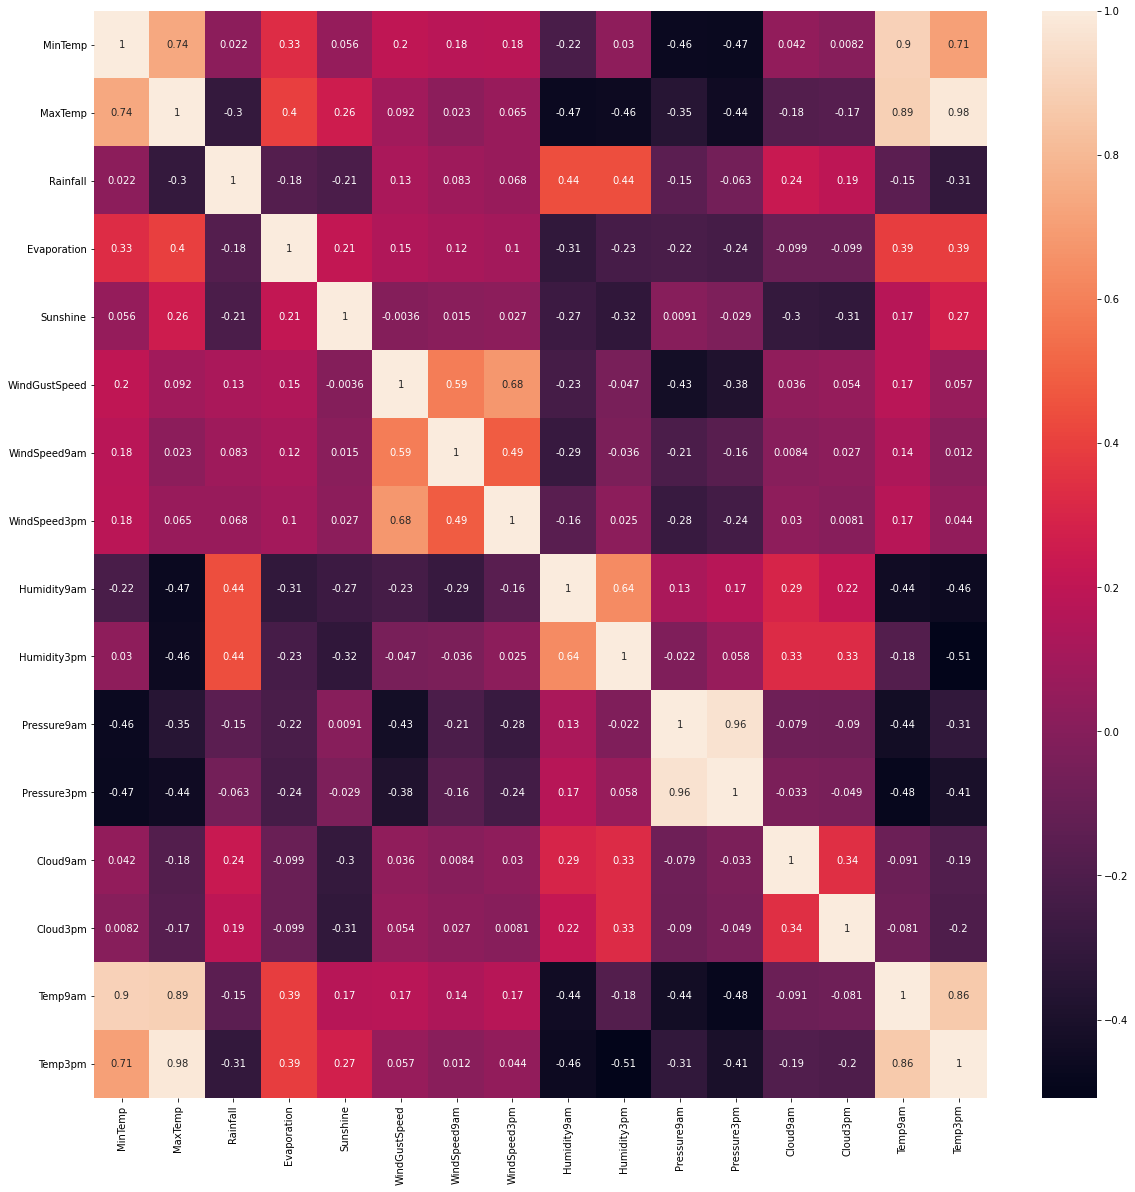

In [9]:
corr=dataset.corr(method='spearman')
plt.figure(figsize=(20,20))
fig=sns.heatmap(corr, annot=True)

In [10]:
print(contineus_feature)
print(discrete_feature)

['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm']
['Cloud9am', 'Cloud3pm']


C:\Users\swapn\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


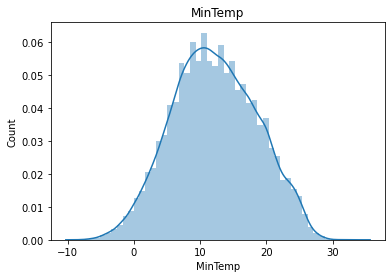

<Figure size 1080x1080 with 0 Axes>

C:\Users\swapn\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


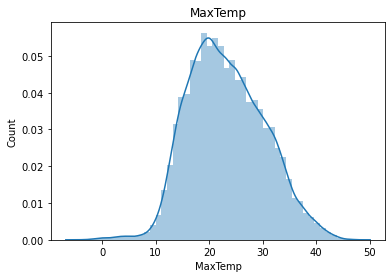

<Figure size 1080x1080 with 0 Axes>

C:\Users\swapn\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


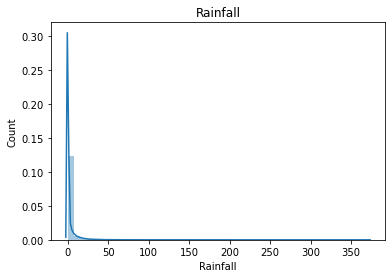

<Figure size 1080x1080 with 0 Axes>

C:\Users\swapn\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


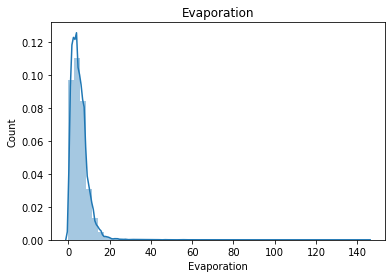

<Figure size 1080x1080 with 0 Axes>

C:\Users\swapn\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


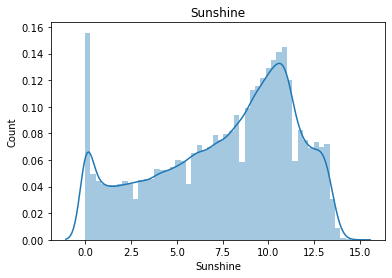

<Figure size 1080x1080 with 0 Axes>

C:\Users\swapn\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


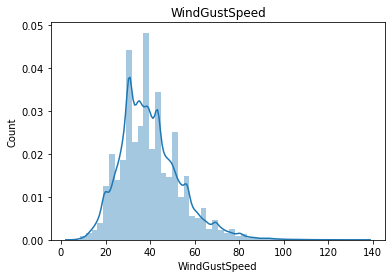

<Figure size 1080x1080 with 0 Axes>

C:\Users\swapn\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


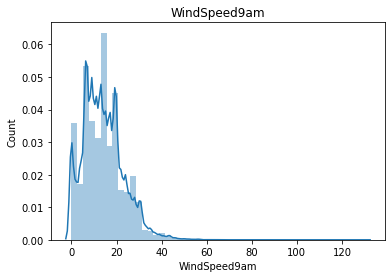

<Figure size 1080x1080 with 0 Axes>

C:\Users\swapn\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


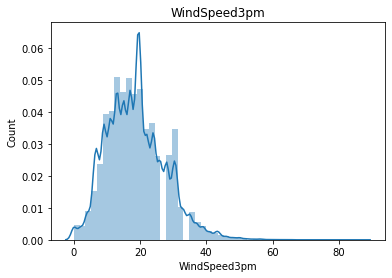

<Figure size 1080x1080 with 0 Axes>

C:\Users\swapn\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


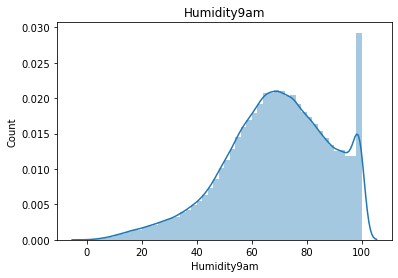

<Figure size 1080x1080 with 0 Axes>

C:\Users\swapn\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


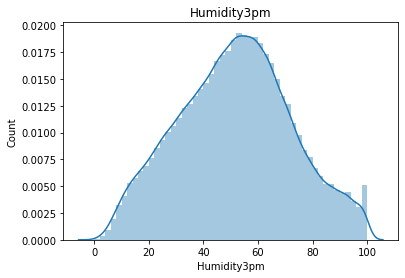

<Figure size 1080x1080 with 0 Axes>

C:\Users\swapn\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


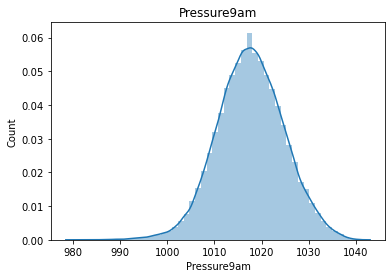

<Figure size 1080x1080 with 0 Axes>

C:\Users\swapn\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


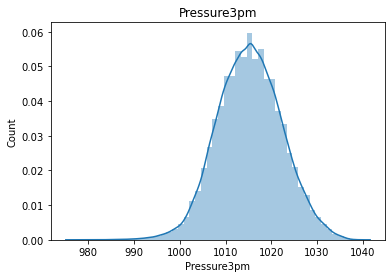

<Figure size 1080x1080 with 0 Axes>

C:\Users\swapn\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


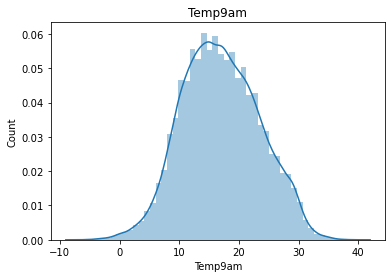

<Figure size 1080x1080 with 0 Axes>

C:\Users\swapn\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


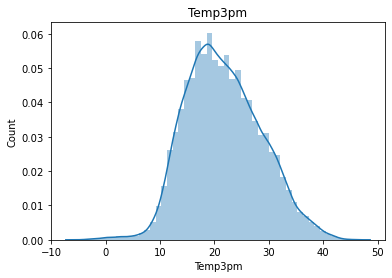

<Figure size 1080x1080 with 0 Axes>

In [11]:
for feature in contineus_feature:
    data=dataset.copy()
    sns.distplot(dataset[feature])
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.title(feature)
    plt.figure(figsize=(15,15))
    plt.show()

C:\Users\swapn\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


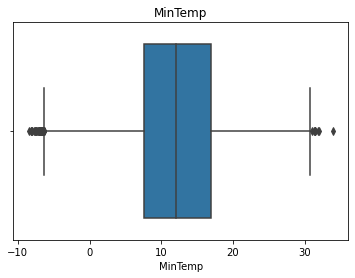

C:\Users\swapn\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


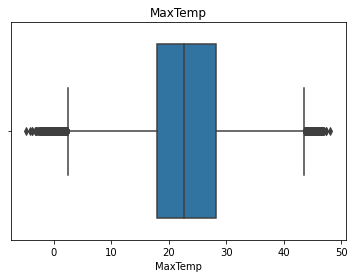

C:\Users\swapn\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


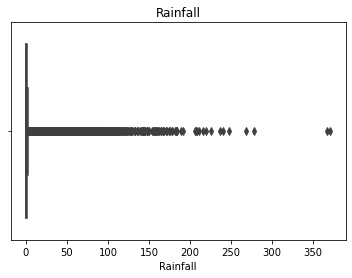

C:\Users\swapn\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


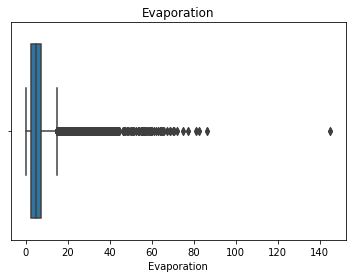

C:\Users\swapn\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


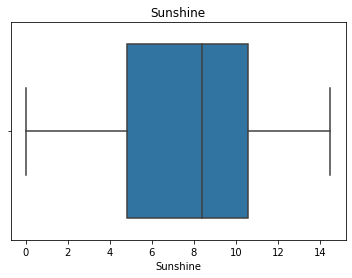

C:\Users\swapn\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


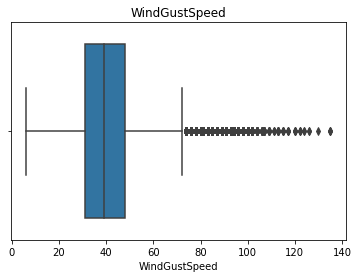

C:\Users\swapn\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


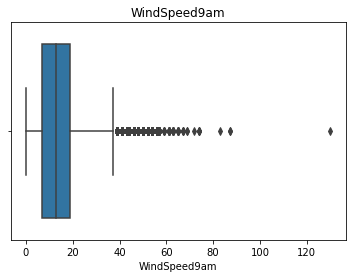

C:\Users\swapn\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


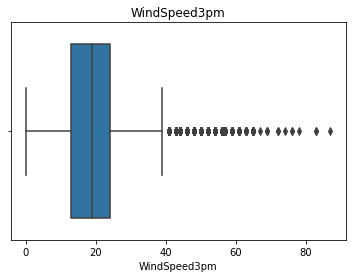

C:\Users\swapn\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


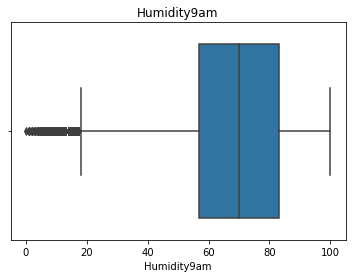

C:\Users\swapn\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


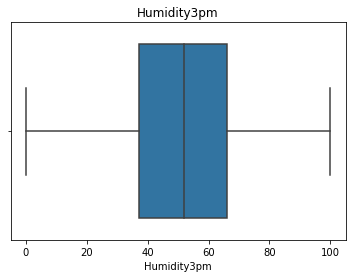

C:\Users\swapn\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


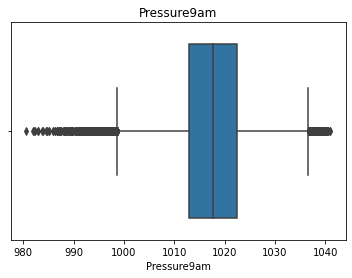

C:\Users\swapn\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


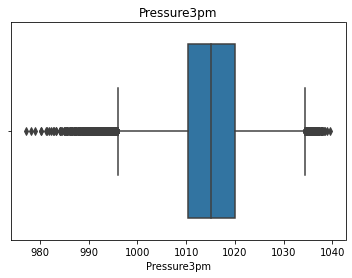

C:\Users\swapn\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


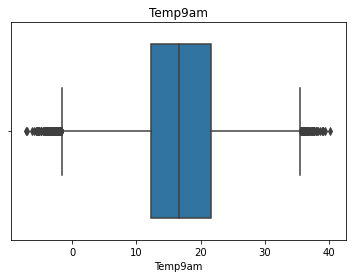

C:\Users\swapn\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


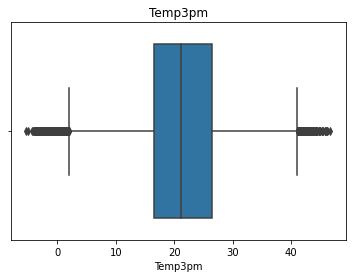

In [12]:
for feature in contineus_feature:
    data=dataset.copy()
    sns.boxplot(dataset[feature])
    plt.title(feature)
    plt.show()

In [13]:
for feature in contineus_feature:
    if(dataset[feature].isnull().sum()*100/len(dataset))>0:
        dataset[feature]=dataset[feature].fillna(dataset[feature].median())

In [14]:
dataset.isnull().sum()*100/(len(dataset))

Date             0.000000
Location         0.000000
MinTemp          0.000000
MaxTemp          0.000000
Rainfall         0.000000
Evaporation      0.000000
Sunshine         0.000000
WindGustDir      7.098859
WindGustSpeed    0.000000
WindDir9am       7.263853
WindDir3pm       2.906641
WindSpeed9am     0.000000
WindSpeed3pm     0.000000
Humidity9am      0.000000
Humidity3pm      0.000000
Pressure9am      0.000000
Pressure3pm      0.000000
Cloud9am         0.000000
Cloud3pm         0.000000
Temp9am          0.000000
Temp3pm          0.000000
RainToday        2.241853
RainTomorrow     2.245978
dtype: float64

In [15]:
def nan(dataset, variable):
    mode=dataset[variable].value_counts().index[0]
    dataset[variable].fillna(mode, inplace=True)
nan(dataset, "Cloud3pm")
nan(dataset, "Cloud9am")

In [16]:
dataset['RainTomorrow']=pd.get_dummies(dataset['RainTomorrow'], drop_first=True)
dataset['RainToday']=pd.get_dummies(dataset['RainToday'], drop_first=True)
dataset

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,2.4,8.3,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,0.0,16.9,21.8,0,0
1,2008-12-02,Albury,7.4,25.1,0.0,3.6,10.0,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,7.0,1.0,17.2,24.3,0,0
2,2008-12-03,Albury,12.9,25.7,0.0,2.6,4.4,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,8.0,2.0,21.0,23.2,0,0
3,2008-12-04,Albury,9.2,28.0,0.0,18.4,8.9,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,0.0,5.0,18.1,26.5,0,0
4,2008-12-05,Albury,17.5,32.3,1.0,5.4,3.0,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,1.4,7.8,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,1.0,1.0,10.1,22.4,0,0
145456,2017-06-22,Uluru,3.6,25.3,0.0,7.6,13.5,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,8.0,5.0,10.9,24.5,0,0
145457,2017-06-23,Uluru,5.4,26.9,0.0,6.8,11.0,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,8.0,1.0,12.5,26.1,0,0
145458,2017-06-24,Uluru,7.8,27.0,0.0,2.6,13.2,SE,28.0,SSE,N,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,0,0


In [17]:
for feature in categorical_feature:
    print(feature, (dataset.groupby(feature)['RainTomorrow'].mean().sort_values(ascending=False)).index)

Date Index(['2007-11-01', '2007-12-15', '2008-02-03', '2008-01-31', '2008-01-30',
       '2008-01-19', '2008-01-18', '2008-01-16', '2008-01-12', '2007-11-30',
       ...
       '2008-05-08', '2008-05-09', '2008-01-03', '2008-01-02', '2008-05-10',
       '2008-05-11', '2008-05-12', '2008-05-13', '2008-05-14', '2007-12-25'],
      dtype='object', name='Date', length=3436)
Location Index(['Portland', 'Walpole', 'Cairns', 'Dartmoor', 'NorfolkIsland',
       'MountGambier', 'Albany', 'Witchcliffe', 'CoffsHarbour', 'MountGinini',
       'NorahHead', 'Darwin', 'Sydney', 'SydneyAirport', 'Ballarat',
       'GoldCoast', 'Watsonia', 'Newcastle', 'Hobart', 'Wollongong',
       'Williamtown', 'Launceston', 'Brisbane', 'MelbourneAirport', 'Adelaide',
       'Sale', 'Albury', 'Perth', 'Melbourne', 'Nuriootpa', 'Penrith',
       'BadgerysCreek', 'PerthAirport', 'Tuggeranong', 'Richmond', 'Bendigo',
       'Canberra', 'WaggaWagga', 'Townsville', 'Katherine', 'PearceRAAF',
       'SalmonGums', 'Nhil', 

In [18]:
WindGustDir={'NNW':0, 'NW':1, 'WNW':2, 'N':3, 'W':4, 'WSW':5, 'NNE':6, 'S':7, 'SSW':8, 'SW':9, 'SSE':10,
       'NE':11, 'SE':12, 'ESE':13, 'ENE':14, 'E':15}
WindDir9am ={'NNW':0, 'N':1, 'NW':2, 'NNE':3, 'WNW':4, 'W':5, 'WSW':6, 'SW':7, 'SSW':8, 'NE':9, 'S':10,
       'SSE':11, 'ENE':12, 'SE':13, 'ESE':14, 'E':15}
WindDir3pm ={'NW':0, 'NNW':1, 'N':2, 'WNW':3, 'W':4, 'NNE':5, 'WSW':6, 'SSW':7, 'S':8, 'SW':9, 'SE':10,
       'NE':11, 'SSE':12, 'ENE':13, 'E':14, 'ESE':15}

dataset['WindGustDir']=dataset['WindGustDir'].map(WindGustDir)
dataset['WindDir9am']=dataset['WindDir9am'].map(WindDir9am)
dataset['WindDir3pm']=dataset['WindDir3pm'].map(WindDir3pm)

In [19]:
dataset['WindGustDir']=dataset['WindGustDir'].fillna(dataset['WindGustDir'].value_counts().index[0])
dataset['WindDir9am']=dataset['WindDir9am'].fillna(dataset['WindDir9am'].value_counts().index[0])
dataset['WindDir3pm']=dataset['WindDir3pm'].fillna(dataset['WindDir3pm'].value_counts().index[0])

In [20]:
dataset.isnull().sum()*100/len(dataset)

Date             0.0
Location         0.0
MinTemp          0.0
MaxTemp          0.0
Rainfall         0.0
Evaporation      0.0
Sunshine         0.0
WindGustDir      0.0
WindGustSpeed    0.0
WindDir9am       0.0
WindDir3pm       0.0
WindSpeed9am     0.0
WindSpeed3pm     0.0
Humidity9am      0.0
Humidity3pm      0.0
Pressure9am      0.0
Pressure3pm      0.0
Cloud9am         0.0
Cloud3pm         0.0
Temp9am          0.0
Temp3pm          0.0
RainToday        0.0
RainTomorrow     0.0
dtype: float64

In [21]:
df=dataset.groupby(['Location'])['RainTomorrow'].value_counts().sort_values().unstack()
df

RainTomorrow,0,1
Location,,
Adelaide,2505,688
Albany,2138,902
Albury,2422,618
AliceSprings,2796,244
BadgerysCreek,2426,583
Ballarat,2259,781
Bendigo,2478,562
Brisbane,2484,709
Cairns,2090,950


In [22]:
df[1].sort_values(ascending=True).index

Index(['Uluru', 'Woomera', 'Nhil', 'AliceSprings', 'Katherine', 'Mildura',
       'Cobar', 'Moree', 'SalmonGums', 'PearceRAAF', 'Townsville',
       'WaggaWagga', 'Richmond', 'Bendigo', 'PerthAirport', 'Tuggeranong',
       'BadgerysCreek', 'Nuriootpa', 'Penrith', 'Albury', 'Canberra',
       'Melbourne', 'Sale', 'Perth', 'MelbourneAirport', 'Adelaide',
       'Launceston', 'Williamtown', 'Brisbane', 'Wollongong', 'Newcastle',
       'Watsonia', 'Hobart', 'SydneyAirport', 'GoldCoast', 'Ballarat',
       'NorahHead', 'MountGinini', 'Darwin', 'Sydney', 'CoffsHarbour',
       'Witchcliffe', 'Albany', 'NorfolkIsland', 'MountGambier', 'Dartmoor',
       'Walpole', 'Cairns', 'Portland'],
      dtype='object', name='Location')

In [23]:
location={'Uluru':1, 'Woomera':2, 'Nhil':3, 'AliceSprings':4, 'Katherine':5, 'Mildura':6,
       'Cobar':7, 'Moree':8, 'SalmonGums':9, 'PearceRAAF':10, 'Townsville':11,
       'WaggaWagga':12, 'Richmond':13, 'Bendigo':14, 'PerthAirport':15, 'Tuggeranong':16,
       'BadgerysCreek':17, 'Nuriootpa':18, 'Penrith':19, 'Albury':20, 'Canberra':21,
       'Melbourne':22, 'Sale':23, 'Perth':24, 'MelbourneAirport':25, 'Adelaide':26,
       'Launceston':27, 'Williamtown':28, 'Brisbane':29, 'Wollongong':30, 'Newcastle':31,
       'Watsonia':32, 'Hobart':33, 'SydneyAirport':34, 'GoldCoast':35, 'Ballarat':36,
       'NorahHead':37, 'MountGinini':38, 'Darwin':39, 'Sydney':40, 'CoffsHarbour':41,
       'Witchcliffe':42, 'Albany':43, 'NorfolkIsland':44, 'MountGambier':45, 'Dartmoor':46,
       'Walpole':47, 'Cairns':48, 'Portland':49}

dataset["Location"]=dataset["Location"].map(location)

In [24]:
dataset['Date']=pd.to_datetime(dataset["Date"])
dataset["Date_day"] = dataset["Date"].dt.day
dataset["Date_month"] = dataset["Date"].dt.month


In [25]:
dataset

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Date_day,Date_month
0,2008-12-01,20,13.4,22.9,0.6,2.4,8.3,4.0,44.0,5.0,3.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,0.0,16.9,21.8,0,0,1,12
1,2008-12-02,20,7.4,25.1,0.0,3.6,10.0,2.0,44.0,0.0,6.0,4.0,22.0,44.0,25.0,1010.6,1007.8,7.0,1.0,17.2,24.3,0,0,2,12
2,2008-12-03,20,12.9,25.7,0.0,2.6,4.4,5.0,46.0,5.0,6.0,19.0,26.0,38.0,30.0,1007.6,1008.7,8.0,2.0,21.0,23.2,0,0,3,12
3,2008-12-04,20,9.2,28.0,0.0,18.4,8.9,11.0,24.0,13.0,14.0,11.0,9.0,45.0,16.0,1017.6,1012.8,0.0,5.0,18.1,26.5,0,0,4,12
4,2008-12-05,20,17.5,32.3,1.0,5.4,3.0,4.0,41.0,12.0,0.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0,0,5,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,1,2.8,23.4,0.0,1.4,7.8,15.0,31.0,13.0,13.0,13.0,11.0,51.0,24.0,1024.6,1020.3,1.0,1.0,10.1,22.4,0,0,21,6
145456,2017-06-22,1,3.6,25.3,0.0,7.6,13.5,0.0,22.0,13.0,2.0,13.0,9.0,56.0,21.0,1023.5,1019.1,8.0,5.0,10.9,24.5,0,0,22,6
145457,2017-06-23,1,5.4,26.9,0.0,6.8,11.0,3.0,37.0,13.0,3.0,9.0,9.0,53.0,24.0,1021.0,1016.8,8.0,1.0,12.5,26.1,0,0,23,6
145458,2017-06-24,1,7.8,27.0,0.0,2.6,13.2,12.0,28.0,11.0,2.0,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,0,0,24,6


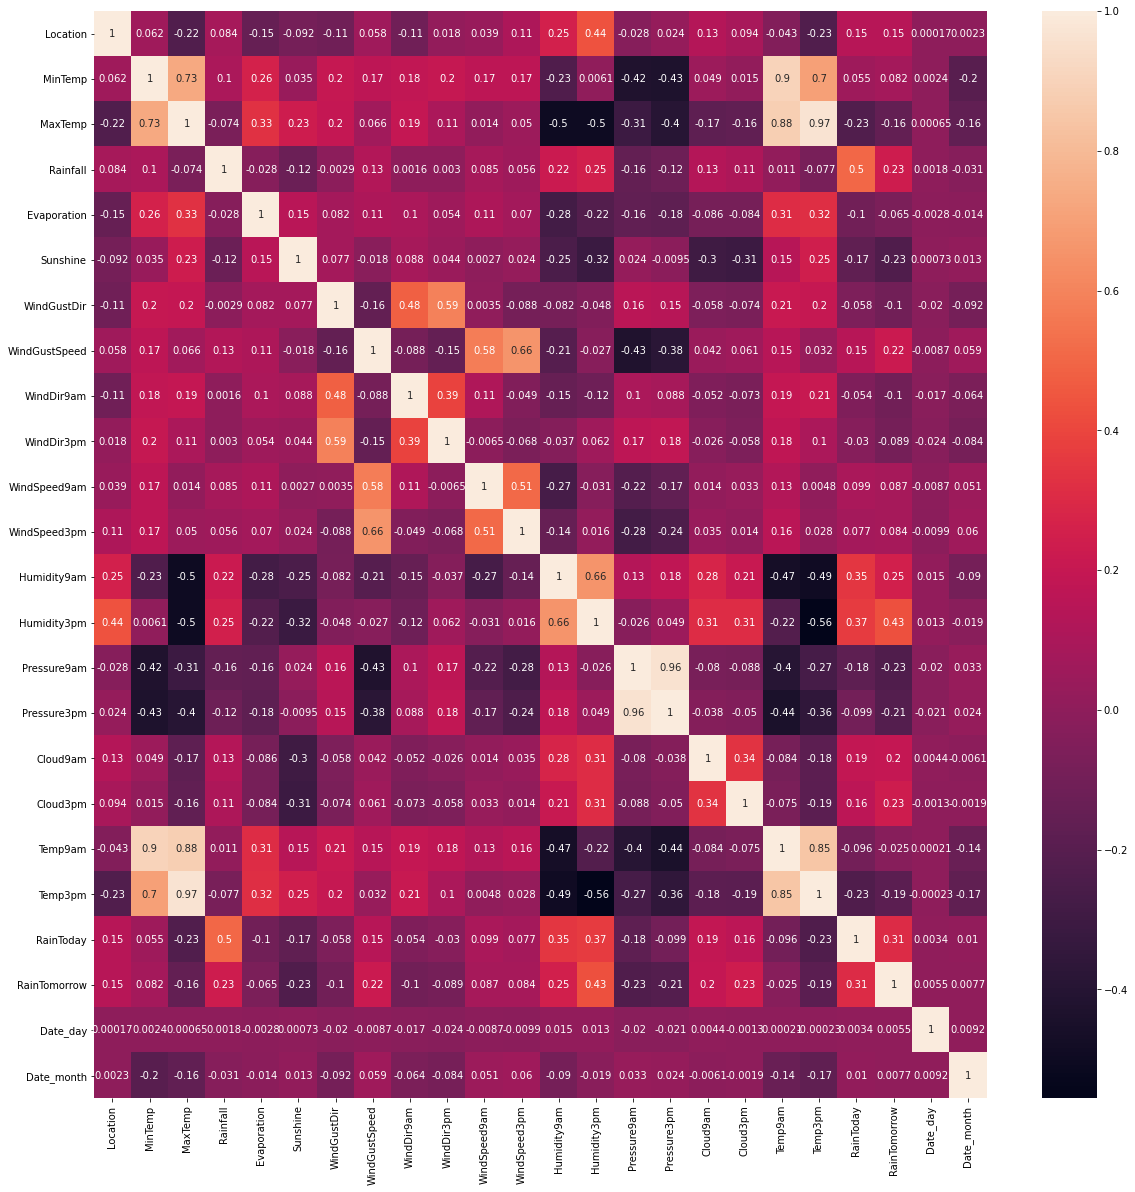

In [26]:
corr=dataset.corr()
plt.figure(figsize=(20,20))
fig=sns.heatmap(corr, annot=True)

C:\Users\swapn\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='RainTomorrow', ylabel='count'>

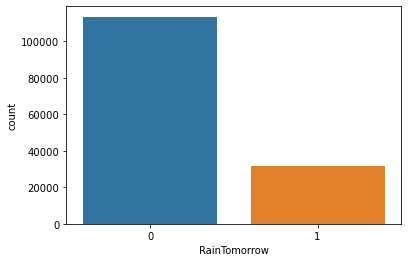

In [27]:
sns.countplot(dataset['RainTomorrow'])

C:\Users\swapn\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\swapn\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\swapn\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\swapn\anaconda3\lib\si

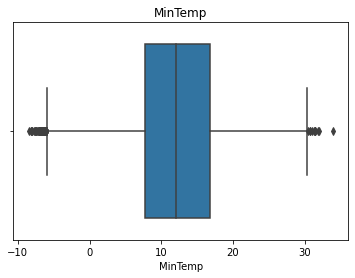

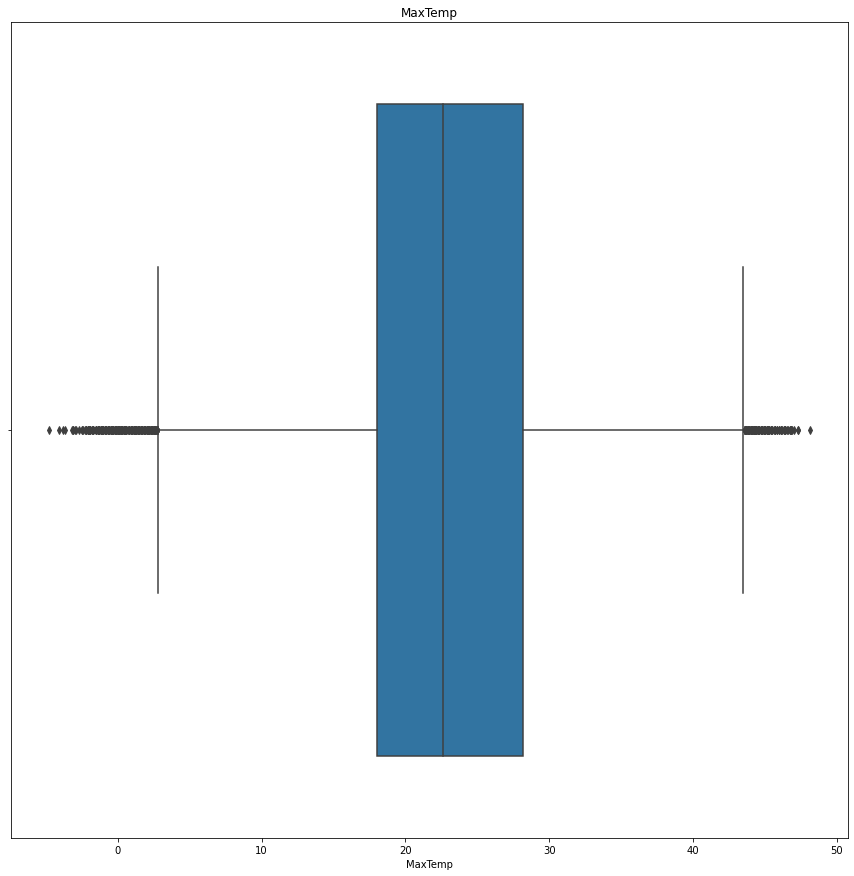

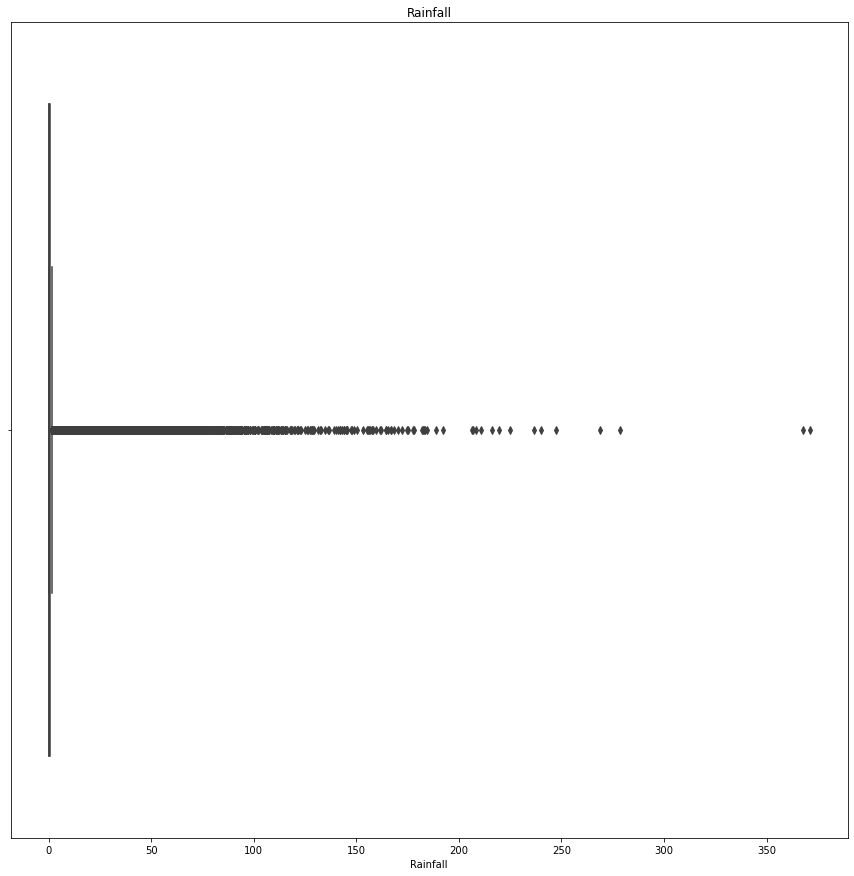

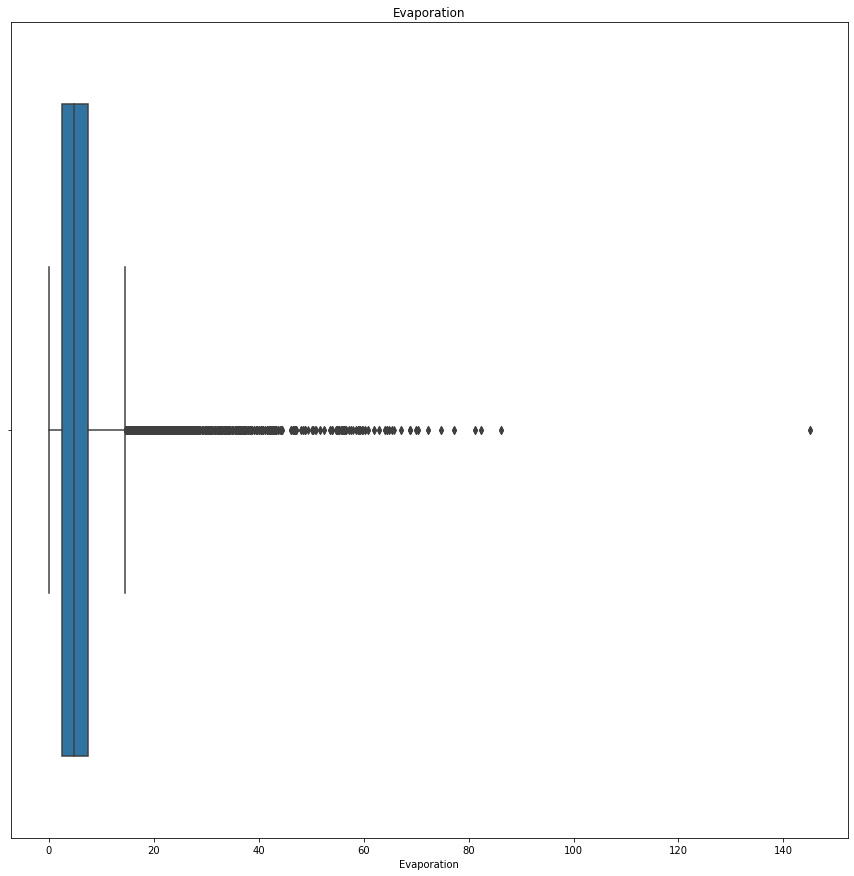

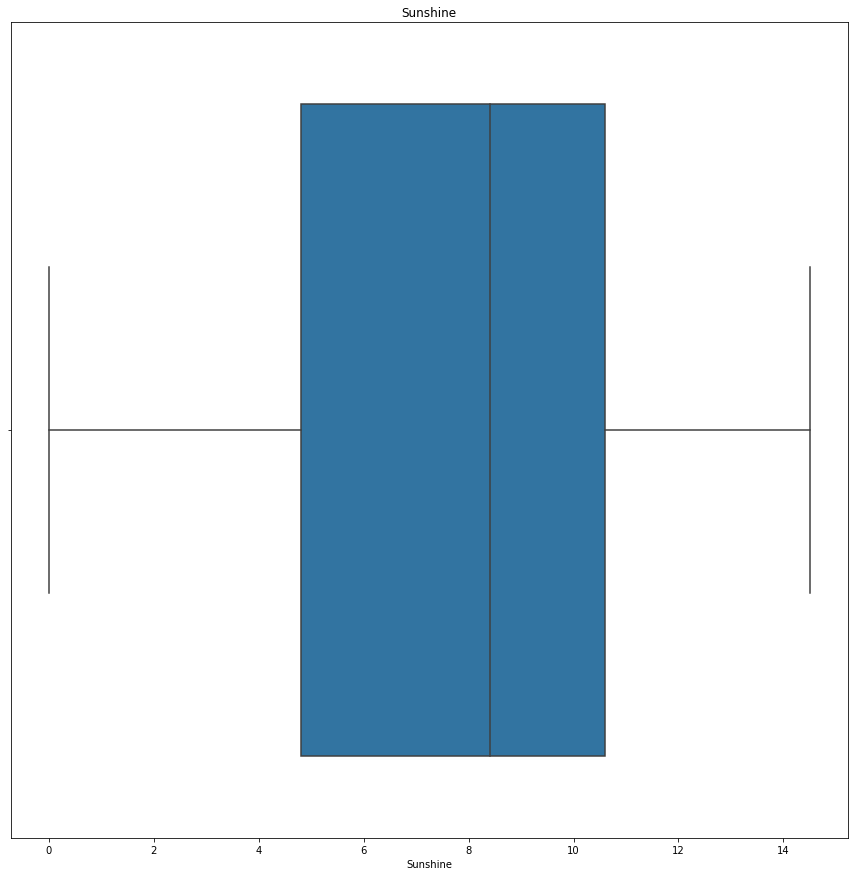

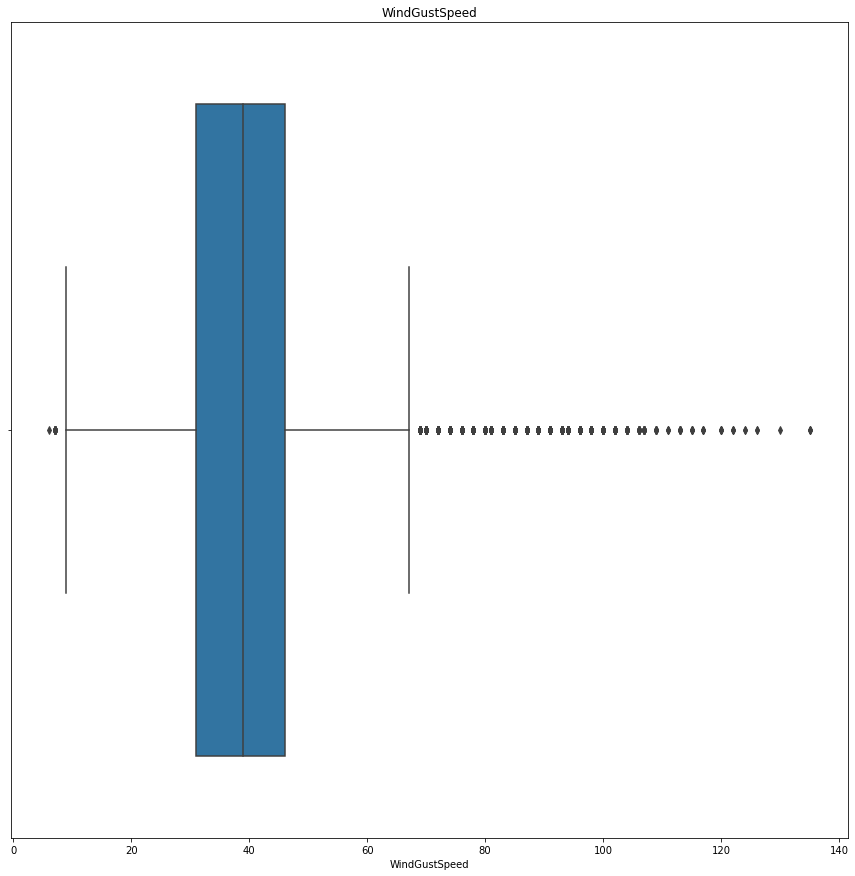

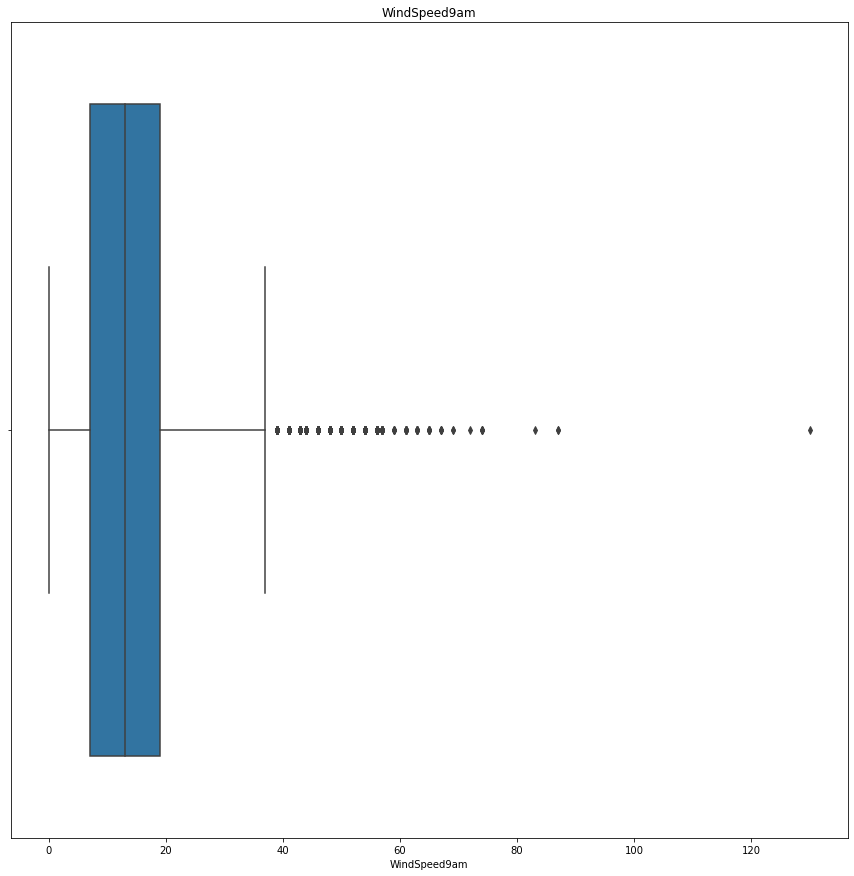

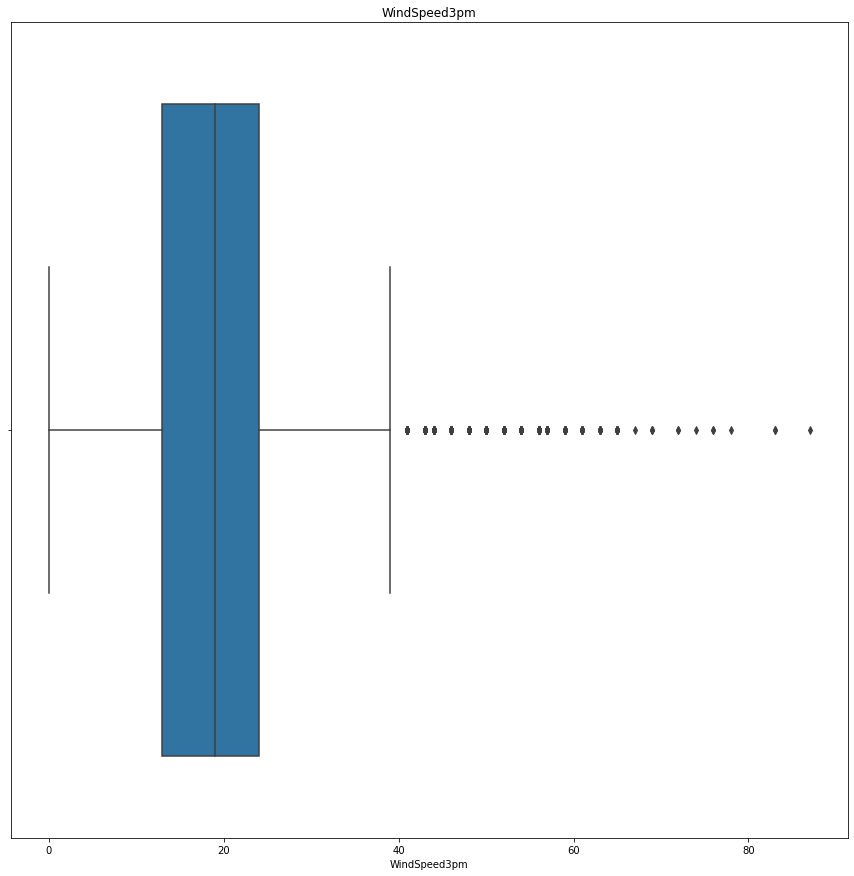

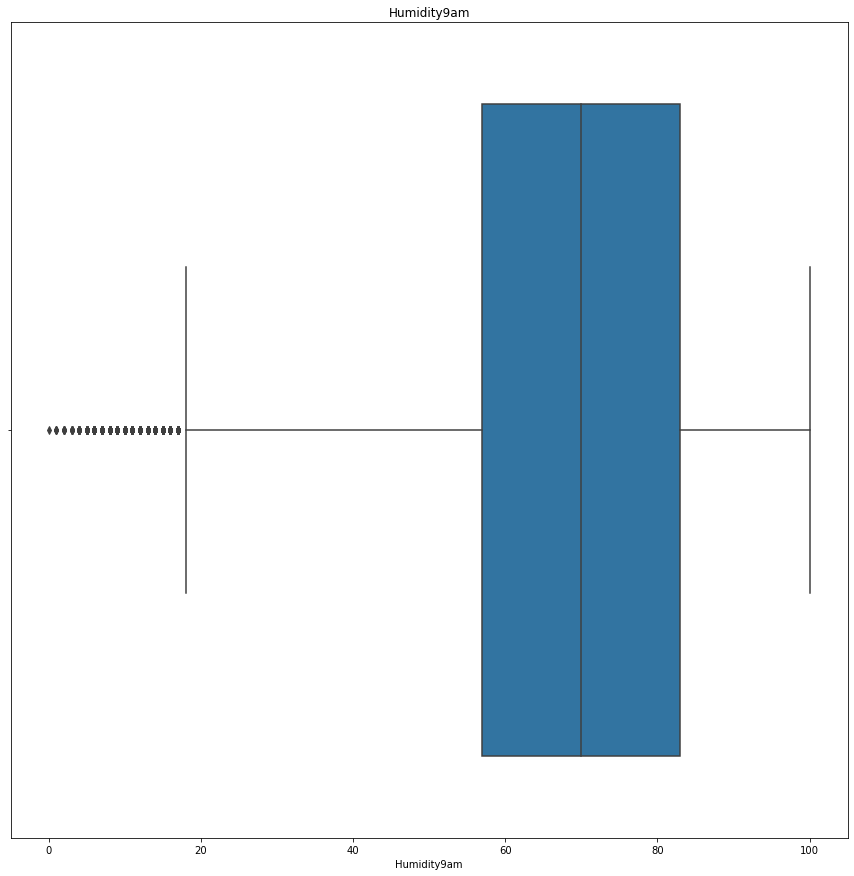

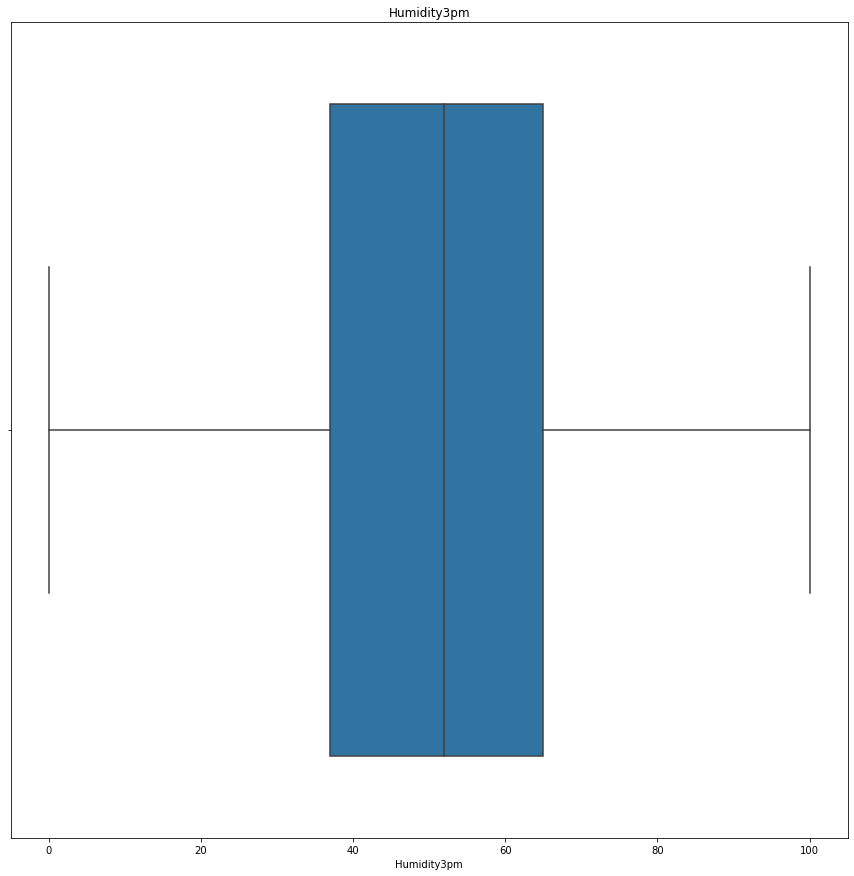

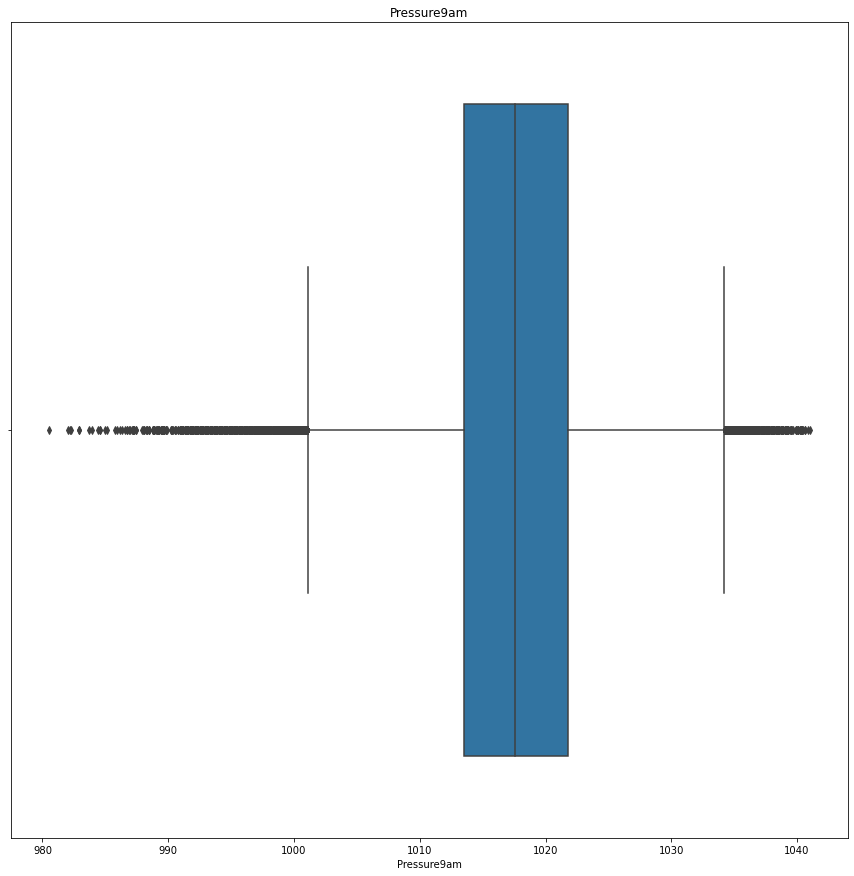

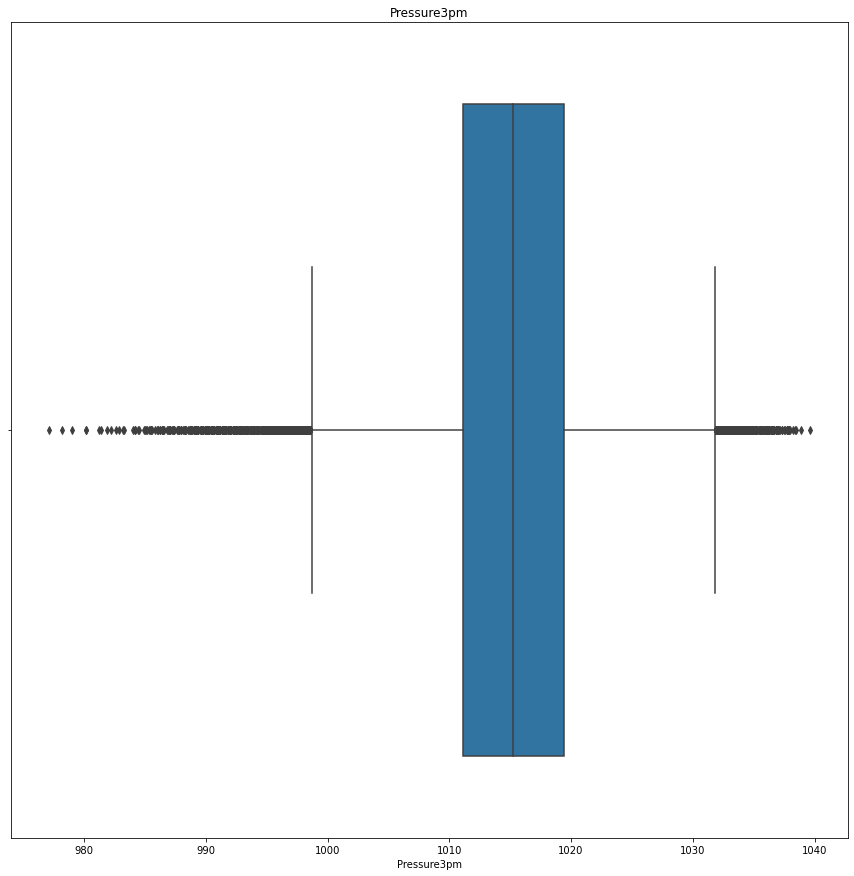

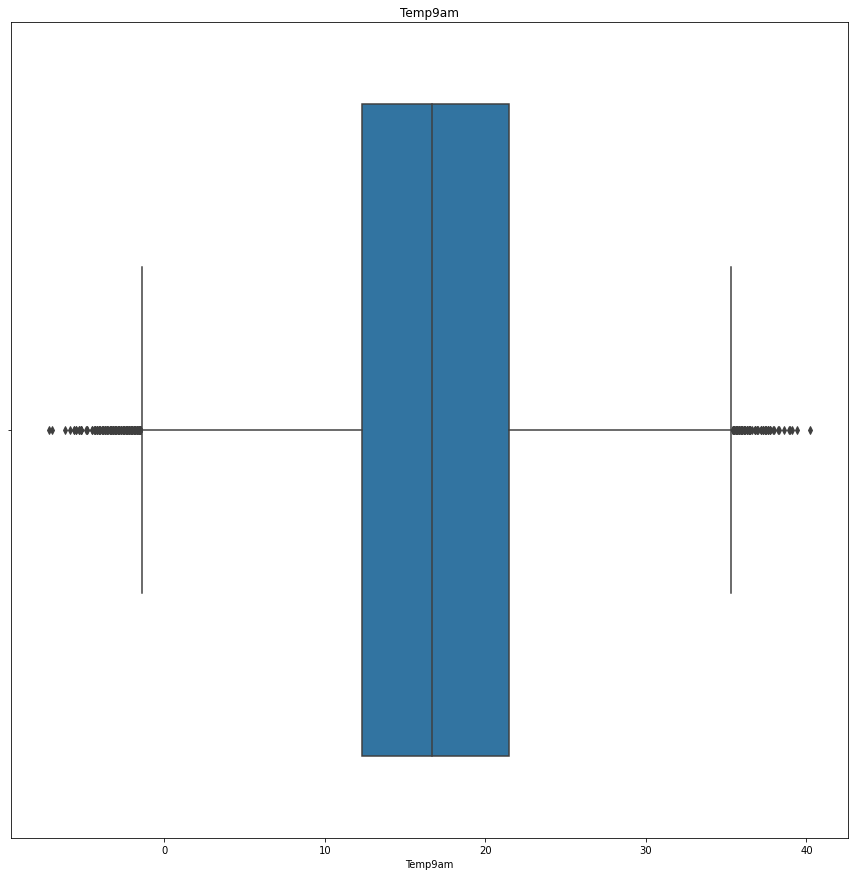

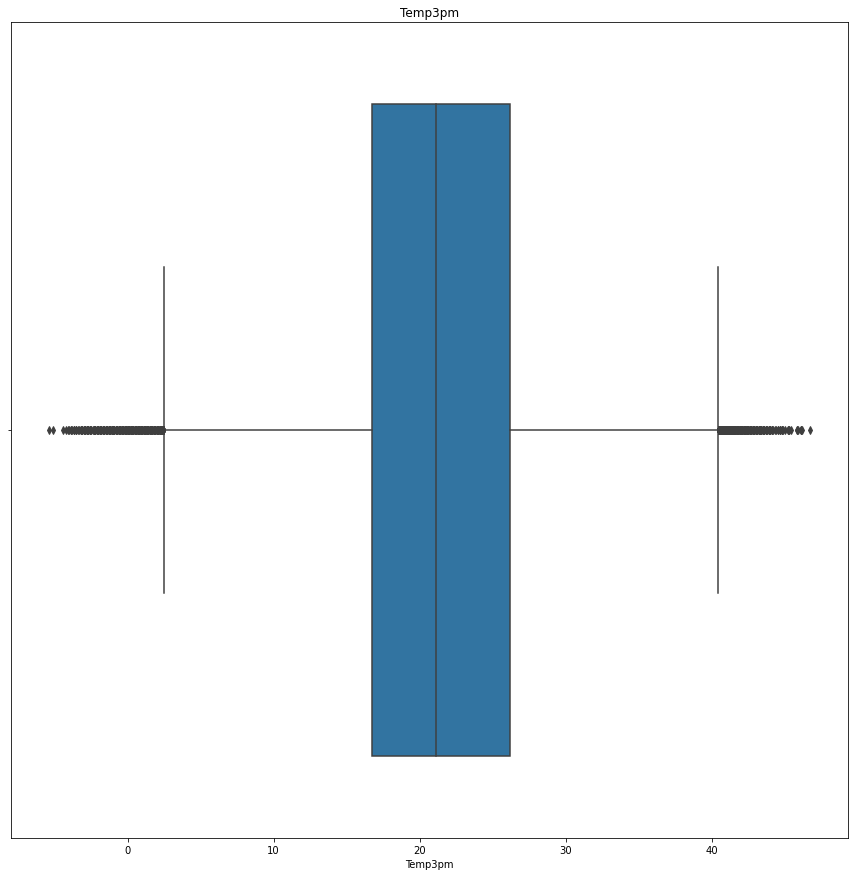

<Figure size 1080x1080 with 0 Axes>

In [28]:
for feature in contineus_feature:
    data=dataset.copy()
    sns.boxplot(data[feature])
    plt.title(feature)
    plt.figure(figsize=(15, 15))

In [29]:
for feature in contineus_feature:
    print(feature)

MinTemp
MaxTemp
Rainfall
Evaporation
Sunshine
WindGustSpeed
WindSpeed9am
WindSpeed3pm
Humidity9am
Humidity3pm
Pressure9am
Pressure3pm
Temp9am
Temp3pm


In [30]:
for feature in contineus_feature:
    IQR=dataset[feature].quantile(0.75)-dataset[feature].quantile(0.25)
    lower_bridge=dataset[feature].quantile(0.25)-(IQR*1.5)
    upper_bridge=dataset[feature].quantile(0.75)+(IQR*1.5)
    print(lower_bridge, upper_bridge)

-5.950000000000002 30.450000000000003
2.700000000000001 43.5
-0.8999999999999999 1.5
-4.600000000000001 14.600000000000001
-3.8999999999999995 19.299999999999997
8.5 68.5
-11.0 37.0
-3.5 40.5
18.0 122.0
-5.0 107.0
1001.0500000000001 1034.25
998.6500000000001 1031.85
-1.4999999999999982 35.3
2.4499999999999993 40.45


In [31]:
dataset.loc[dataset['MinTemp']>=30.45,'MinTemp']=30.45
dataset.loc[dataset['MinTemp']<=-5.95,'MinTemp']=-5.95

In [32]:
dataset.loc[dataset['MaxTemp']>=43.5,'MaxTemp']=43.5
dataset.loc[dataset['MaxTemp']<=2.7,'MaxTemp']=2.7

In [33]:
dataset.loc[dataset['Rainfall']>=1.5,'Rainfall']=1.5
dataset.loc[dataset['Rainfall']<=-0.89,'Rainfall']=-0.89

In [34]:
dataset.loc[dataset['Evaporation']>=14.6,'Evaporation']=14.6
dataset.loc[dataset['Evaporation']<=-4.6,'Evaporation']=-4.6

In [35]:
dataset.loc[dataset['WindGustSpeed']>=68.5,'WindGustSpeed']=68.5
dataset.loc[dataset['WindGustSpeed']<=8.5,'WindGustSpeed']=8.5

In [36]:
dataset.loc[dataset['WindSpeed9am']>=37,'WindSpeed9am']=37
dataset.loc[dataset['WindSpeed9am']<=-11,'WindSpeed9am']=-11

In [37]:
dataset.loc[dataset['WindSpeed3pm']>40.5,'WindSpeed3pm']=40.5
dataset.loc[dataset['WindSpeed3pm']<=-3.5,'WindSpeed3pm']=-3.5

In [38]:
dataset.loc[dataset['Humidity9am']>=122,'Humidity9am']=122
dataset.loc[dataset['Humidity9am']<=18,'Humidity9am']=18

In [39]:
dataset.loc[dataset['Pressure9am']>=1034.25,'Pressure9am']=1034.25
dataset.loc[dataset['Pressure9am']<=1001.05,'Pressure9am']=1001.05

In [40]:
dataset.loc[dataset['Pressure3pm']>=1031.85,'Pressure3pm']=1031.85
dataset.loc[dataset['Pressure3pm']<=998.65,'Pressure3pm']=998.65

In [41]:
dataset.loc[dataset['Temp9am']>=35.3,'Temp9am']=35.3
dataset.loc[dataset['Temp9am']<=-1.49,'Temp9am']=-1.49

In [42]:
dataset.loc[dataset['Temp3pm']>=40.45,'Temp3pm']=40.45
dataset.loc[dataset['Temp3pm']<=2.45,'Temp3pm']=2.45

C:\Users\swapn\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\swapn\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\swapn\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\swapn\anaconda3\lib\si

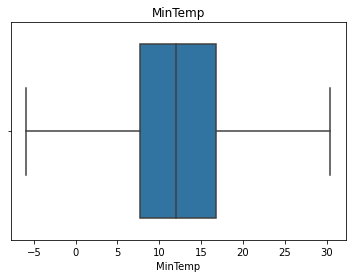

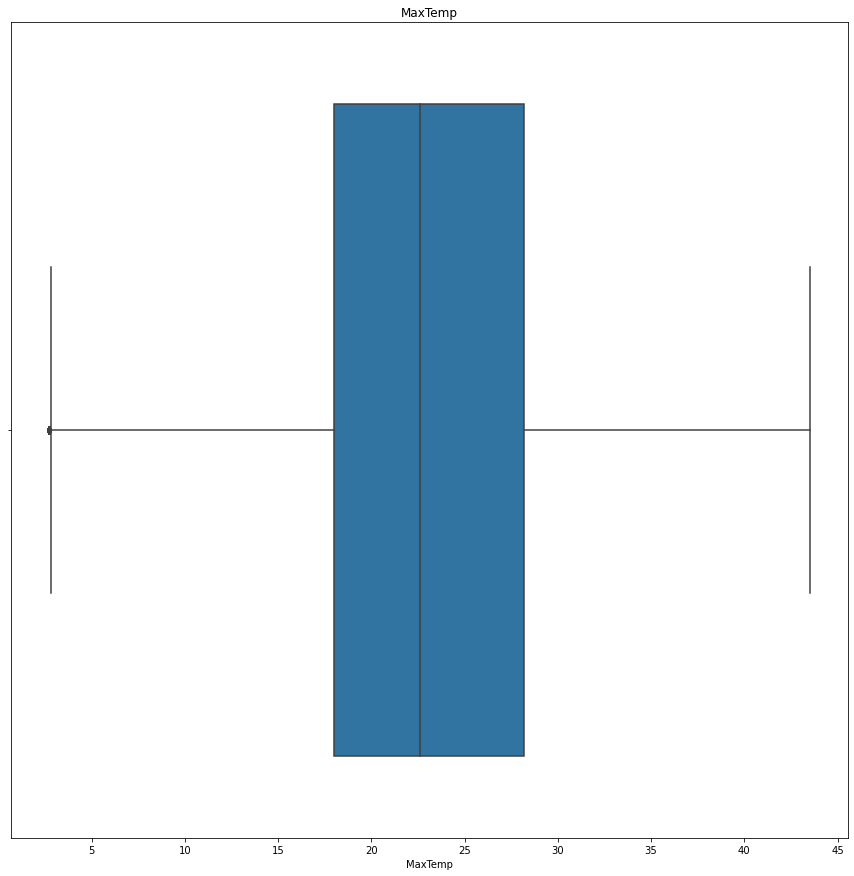

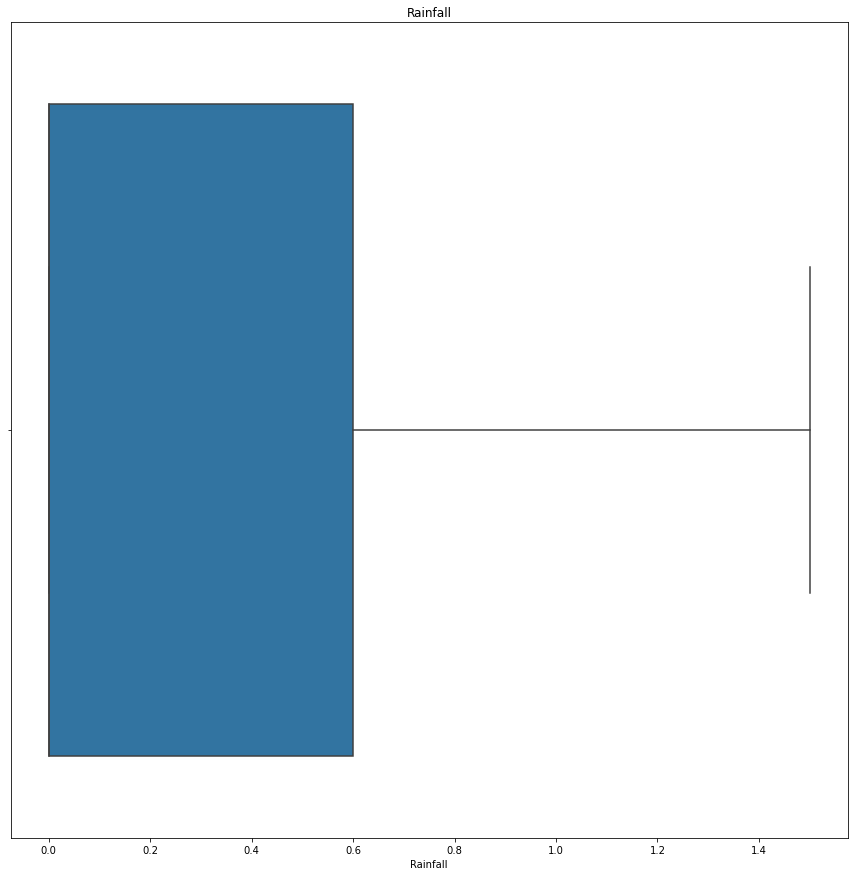

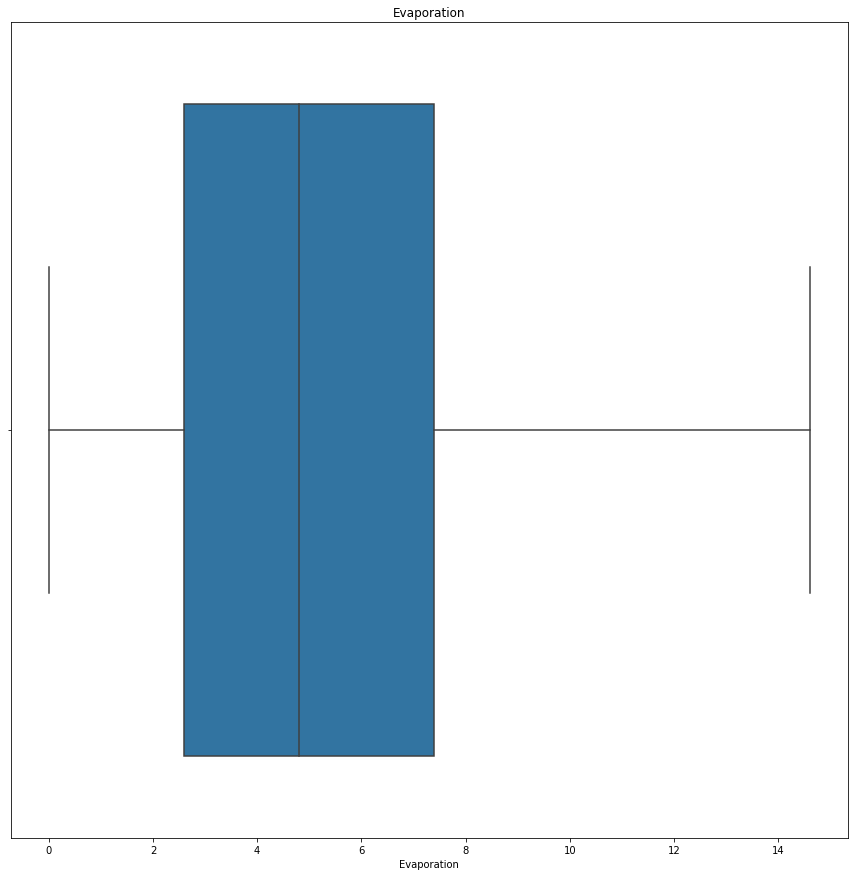

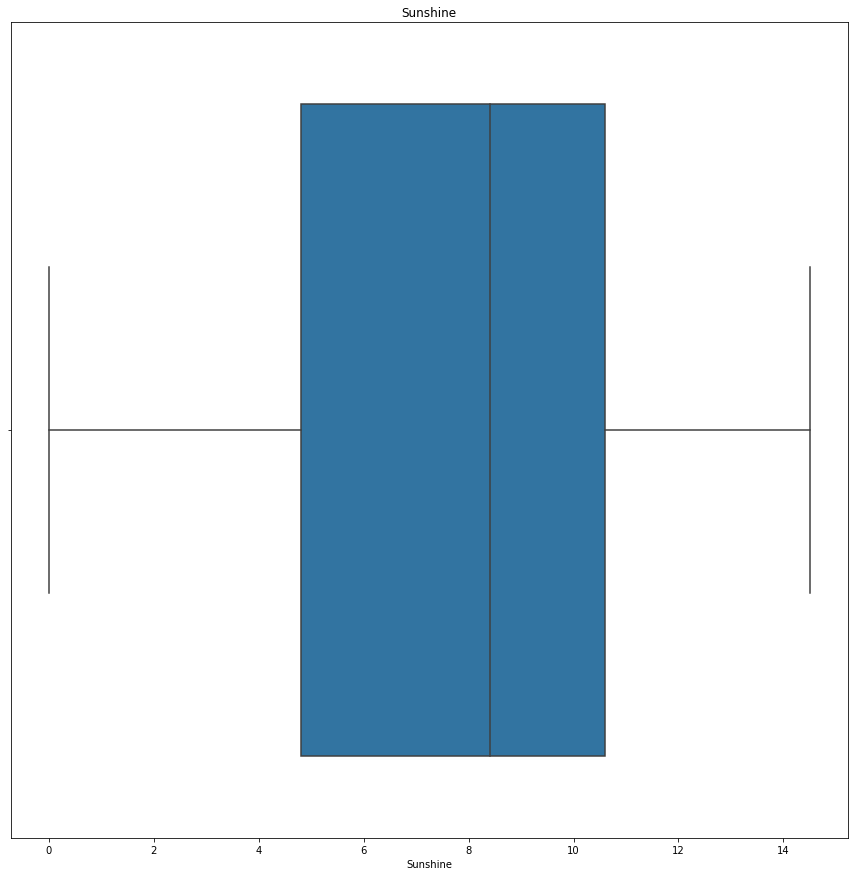

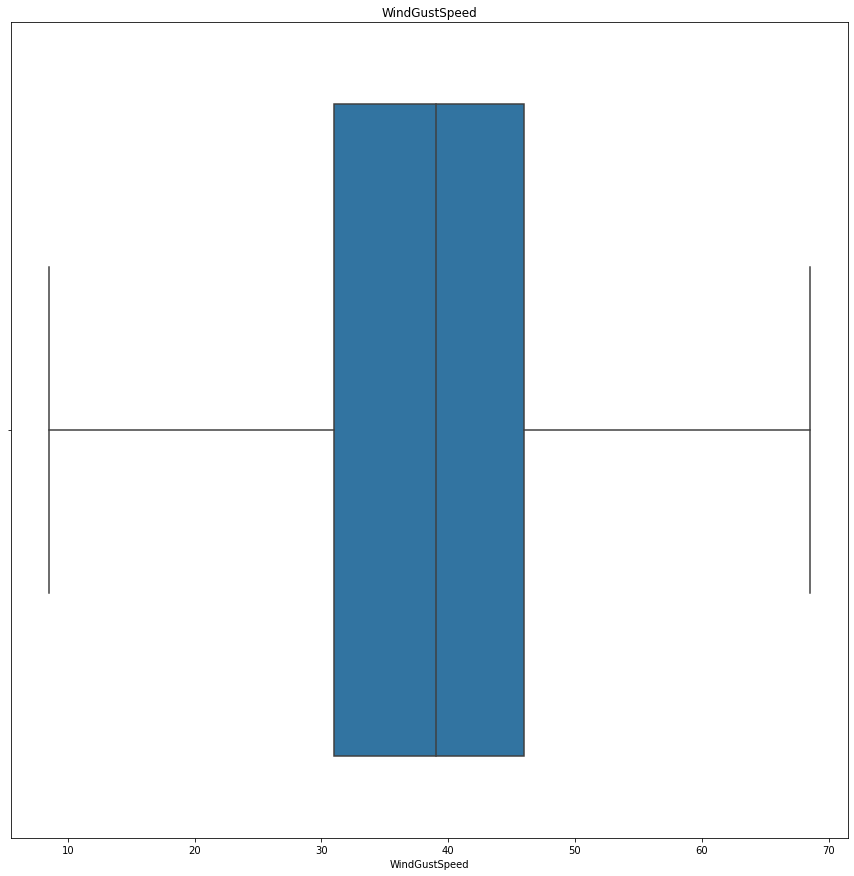

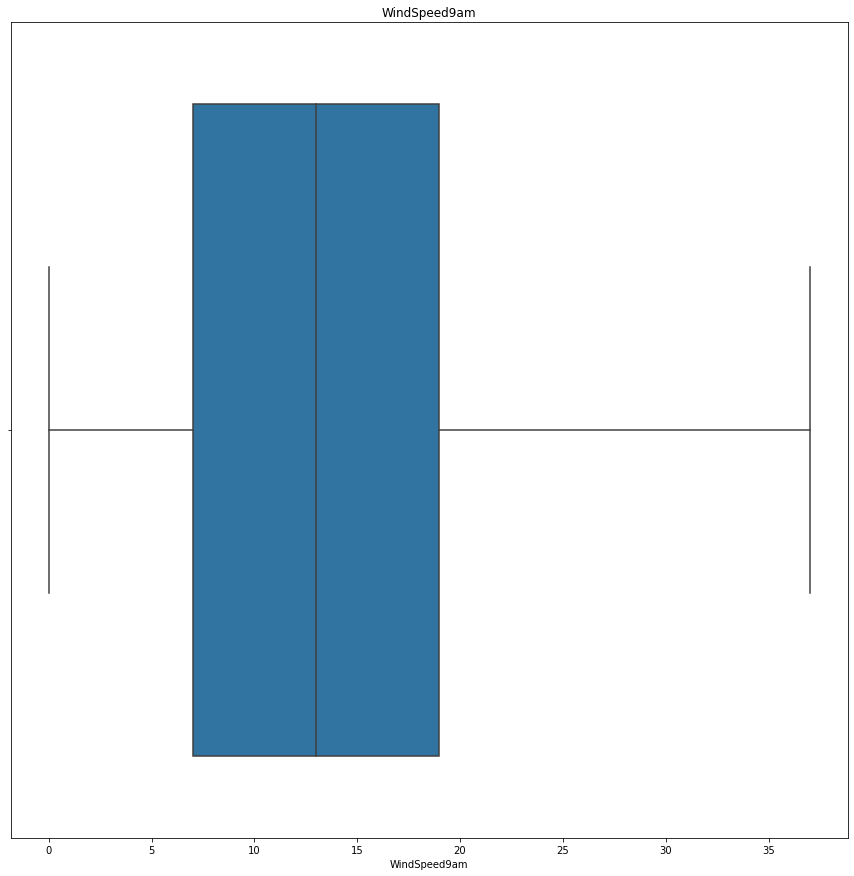

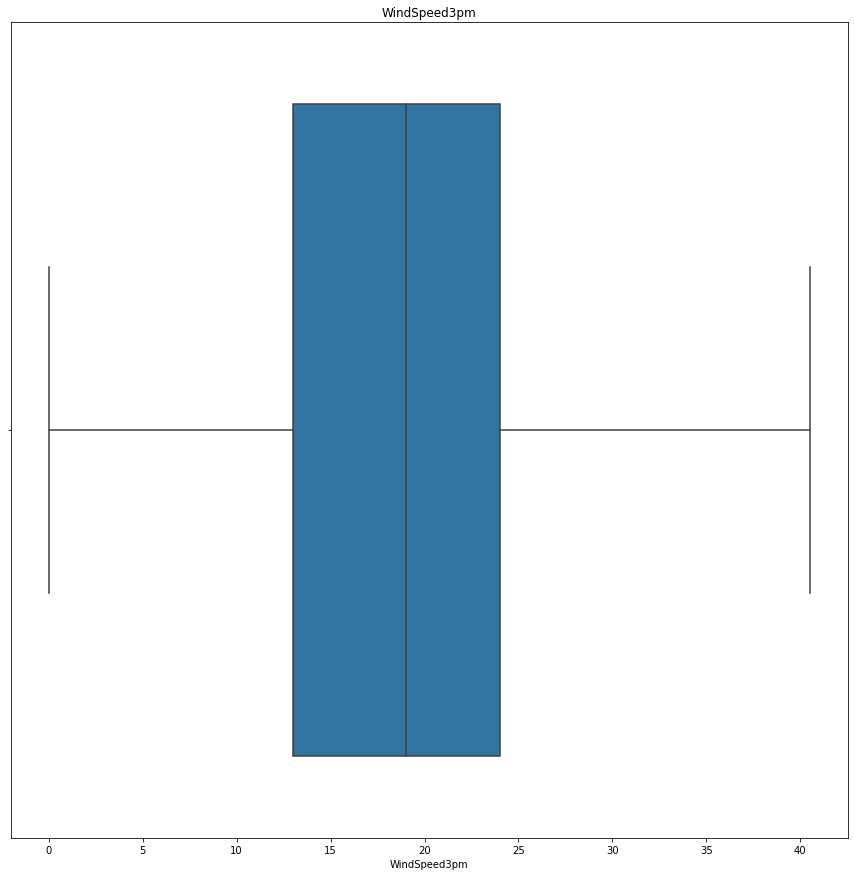

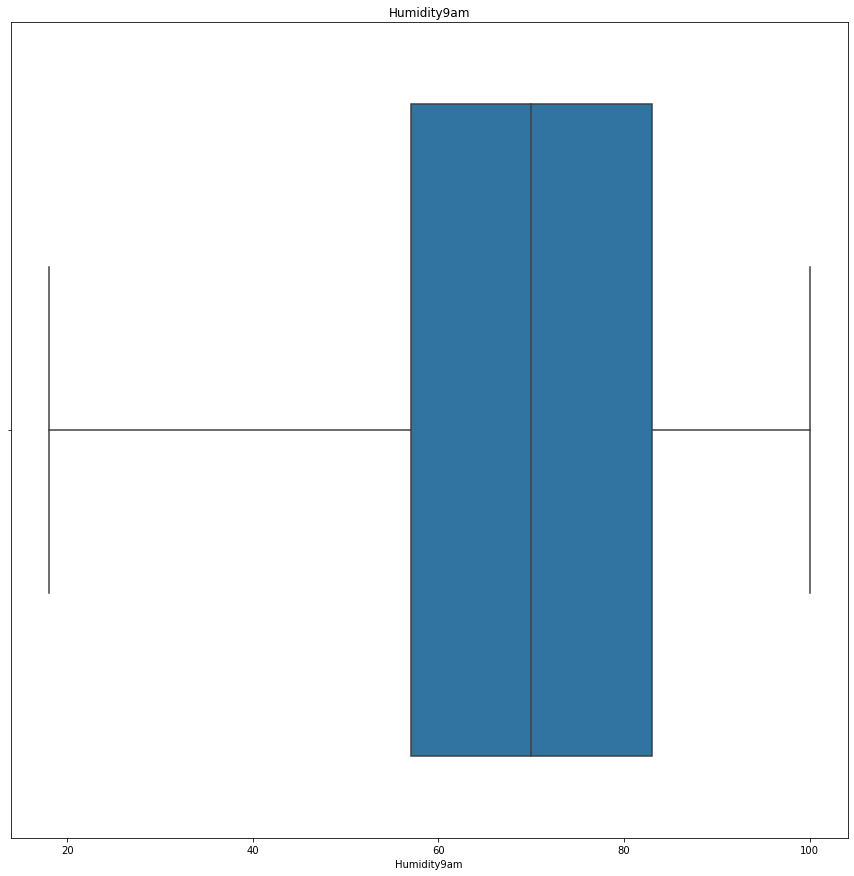

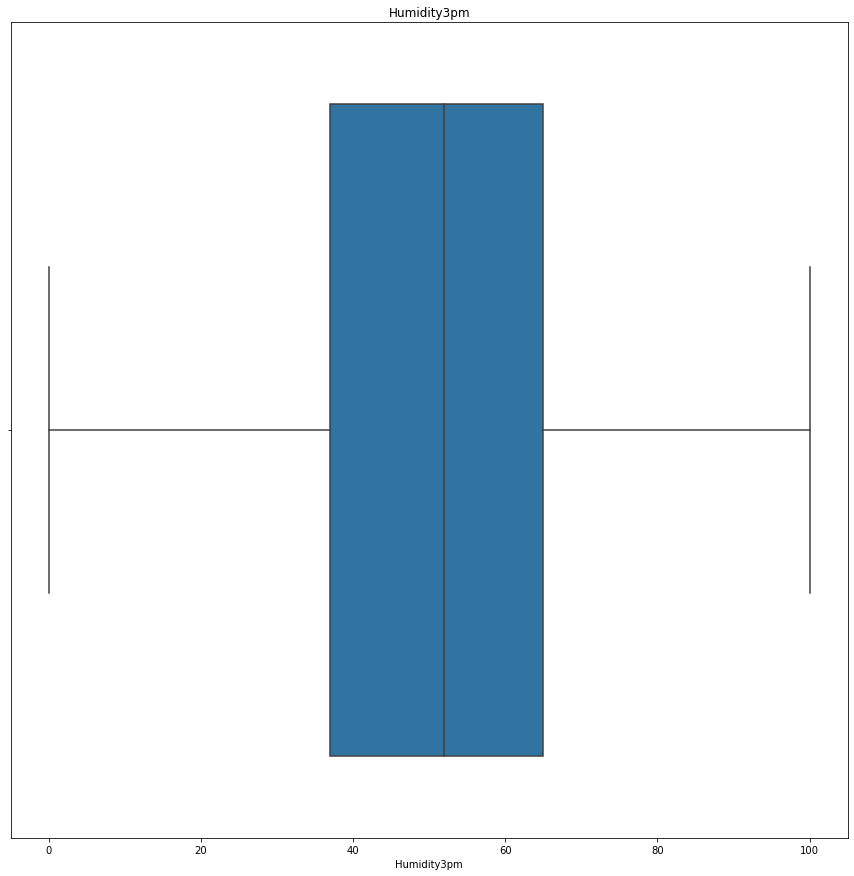

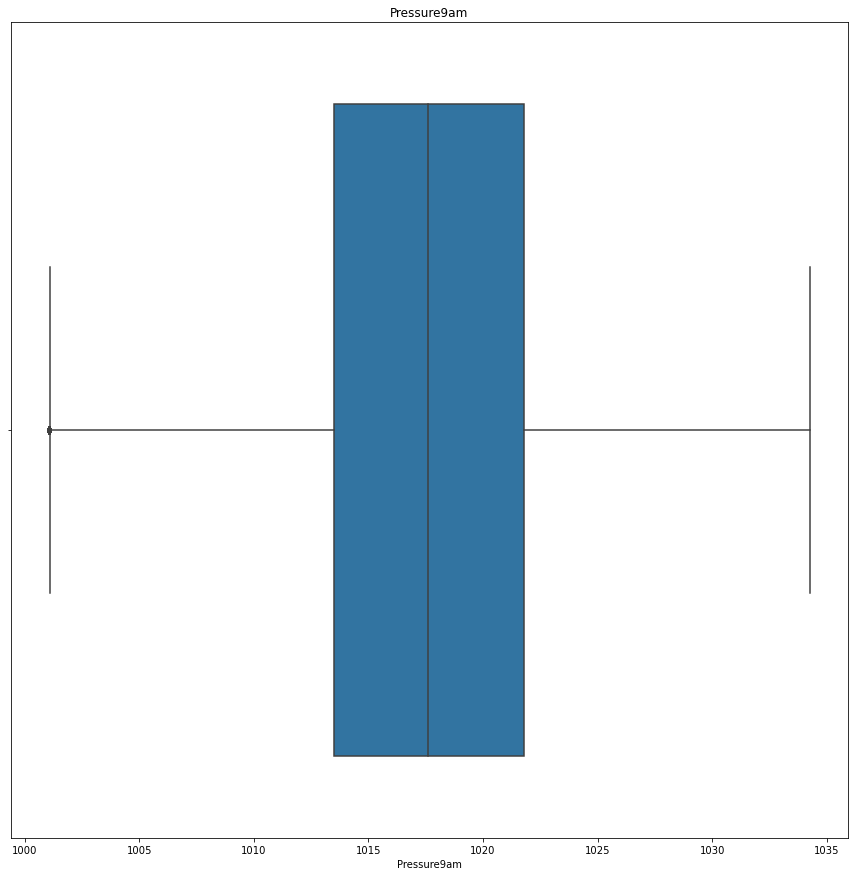

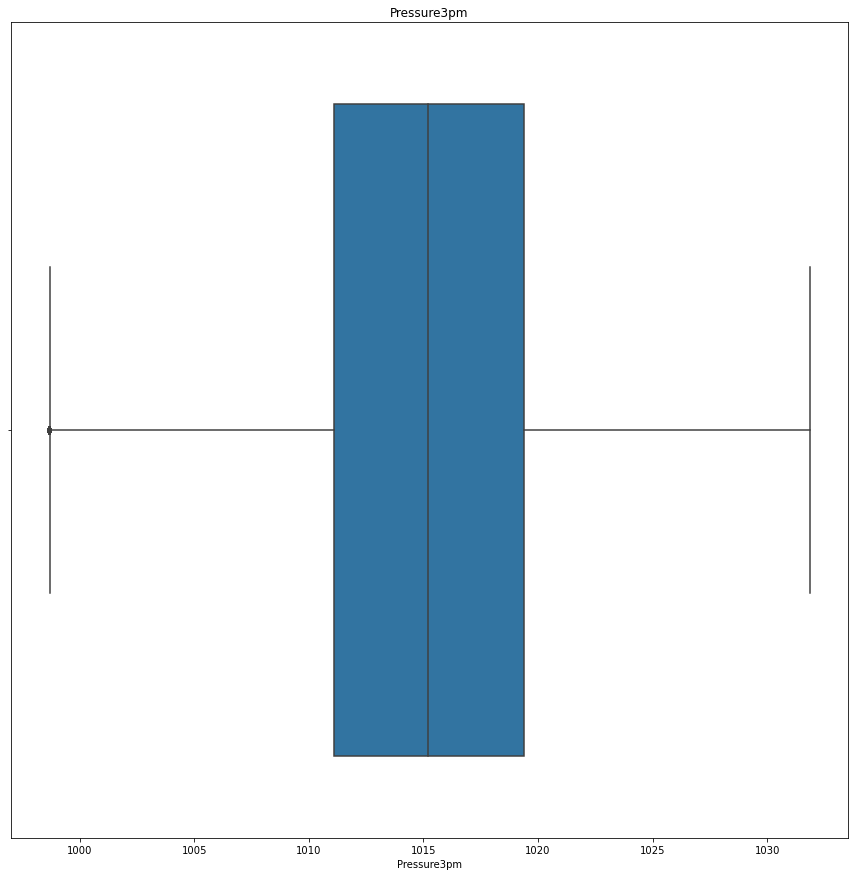

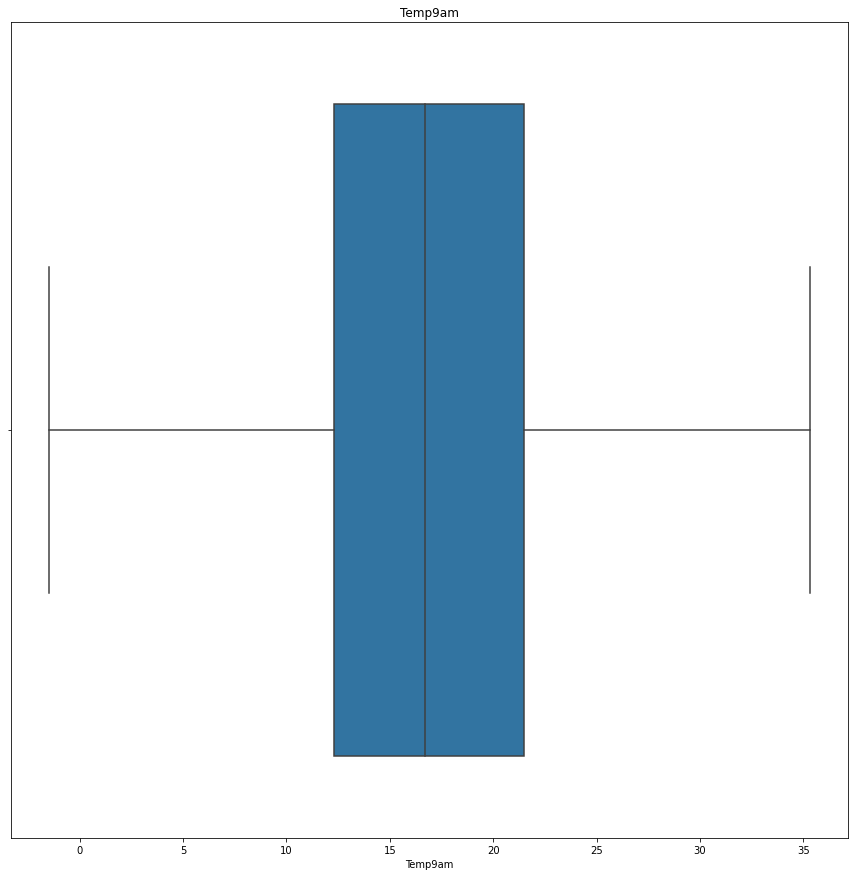

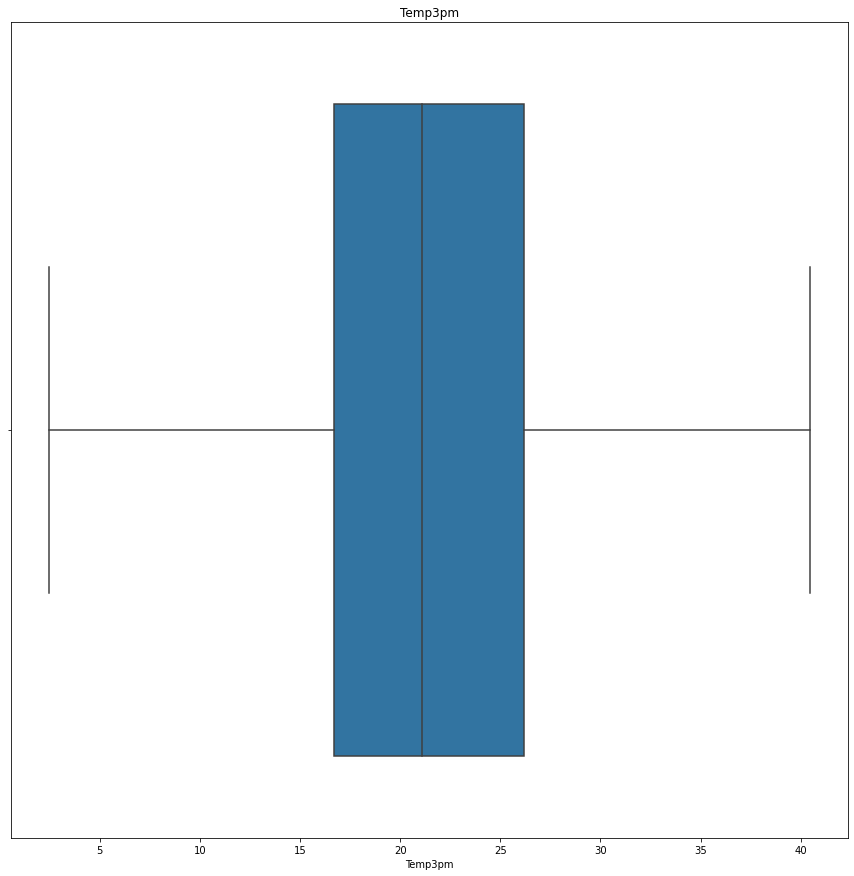

<Figure size 1080x1080 with 0 Axes>

In [43]:
for feature in contineus_feature:
    data=dataset.copy()
    sns.boxplot(data[feature])
    plt.title(feature)
    plt.figure(figsize=(15, 15))

In [44]:
def prob_plots(dataset, variable):
    plt.figure(figsize=(15,15))
    plt.subplot(1,2,1)
    dataset[feature].hist()
    plt.subplot(1,2,1)
    stats.probplot(dataset[variable], dist="norm", plot=plt)
    plt.show()

MinTemp


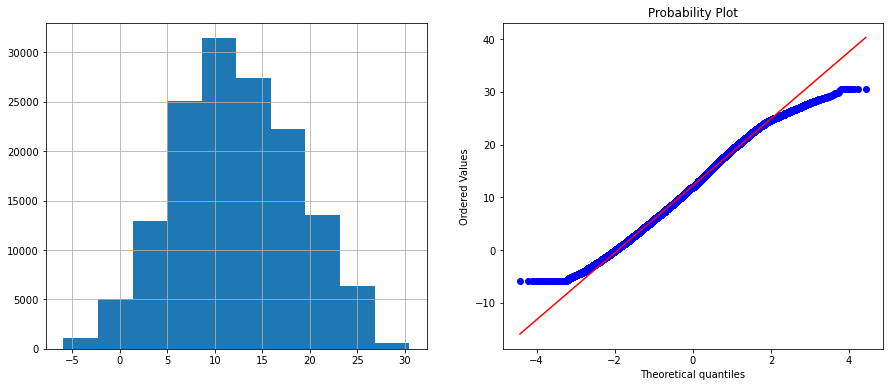

MaxTemp


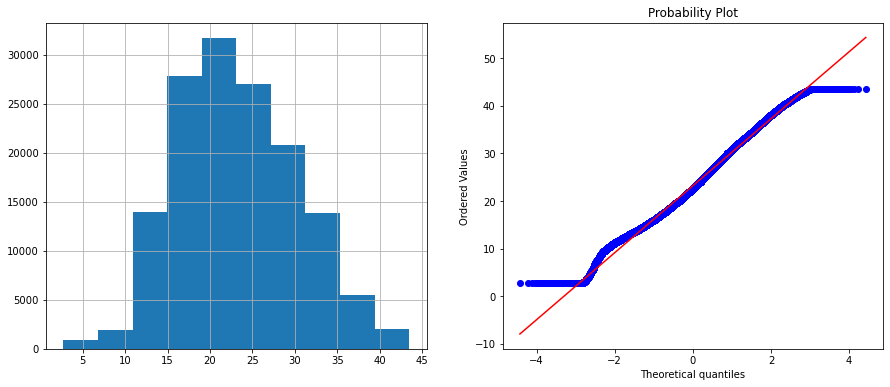

Rainfall


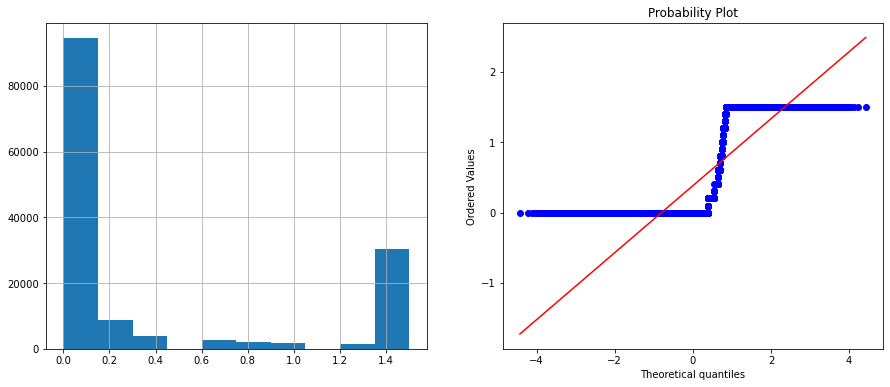

Evaporation


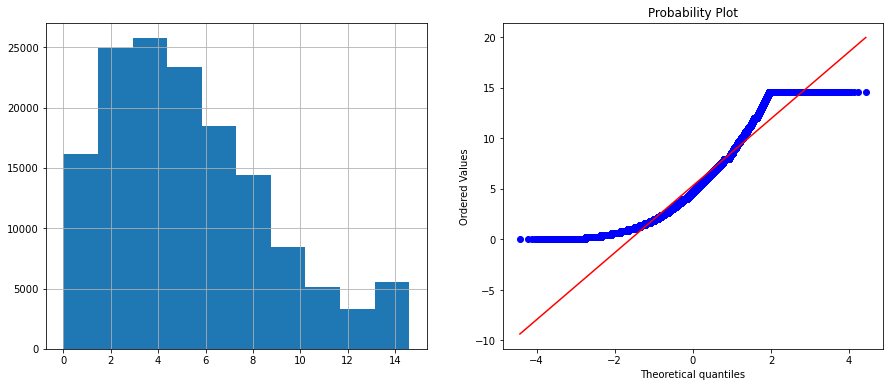

Sunshine


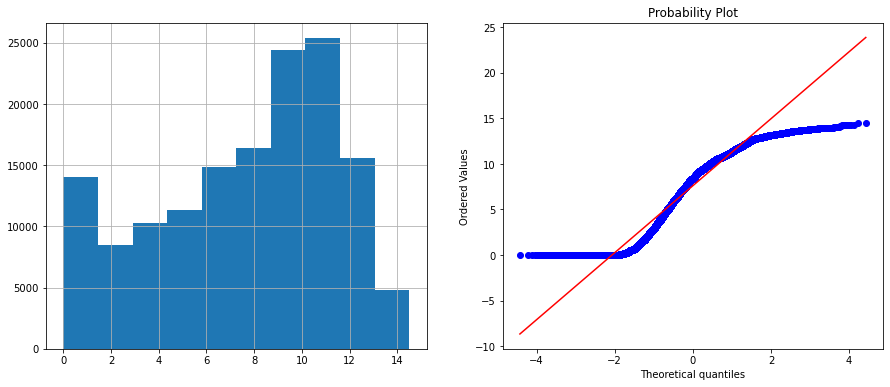

WindGustSpeed


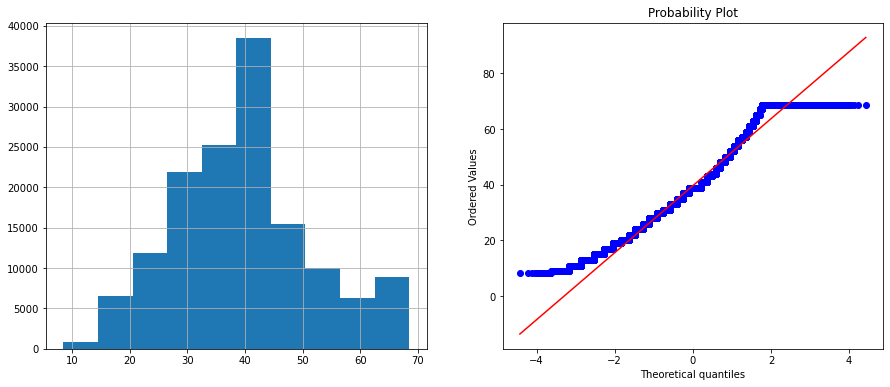

WindSpeed9am


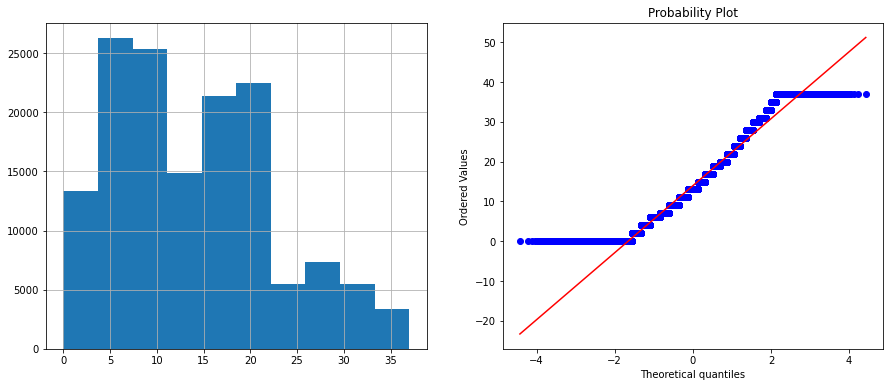

WindSpeed3pm


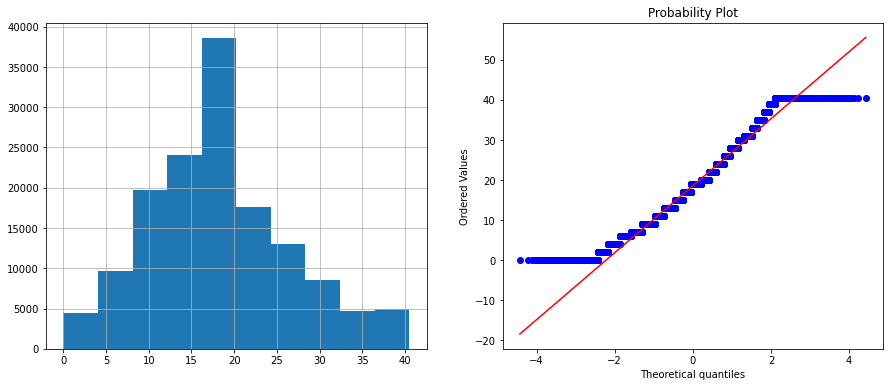

Humidity9am


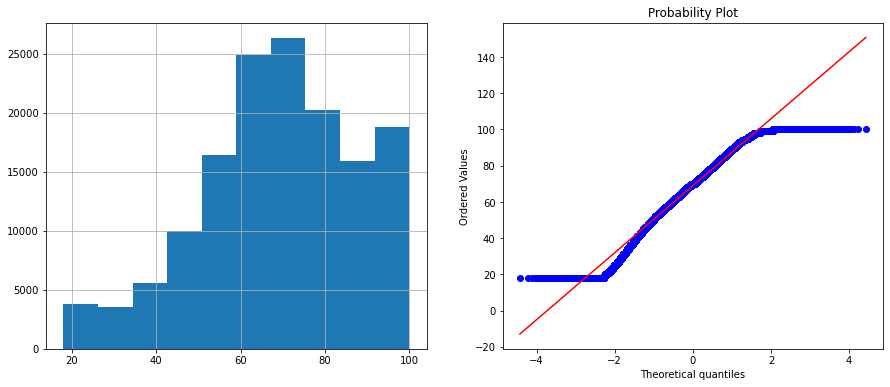

Humidity3pm


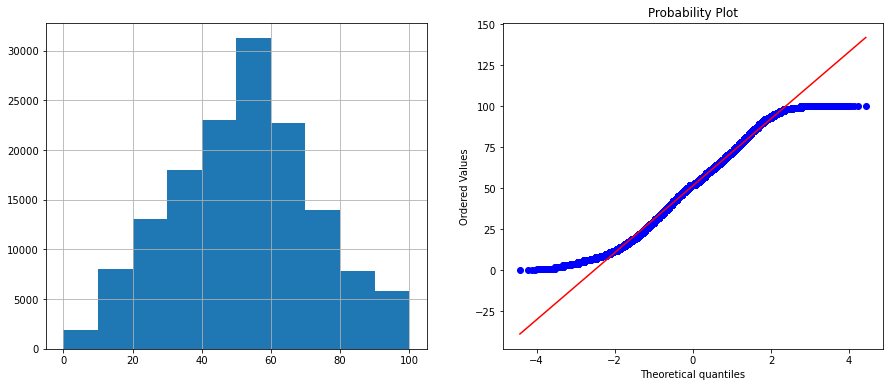

Pressure9am


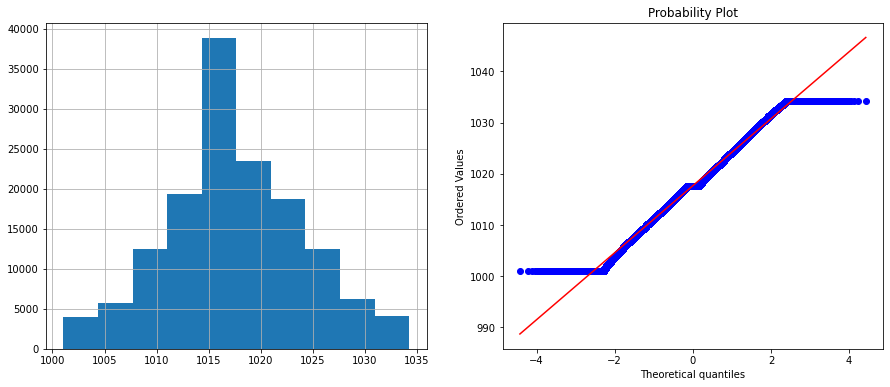

Pressure3pm


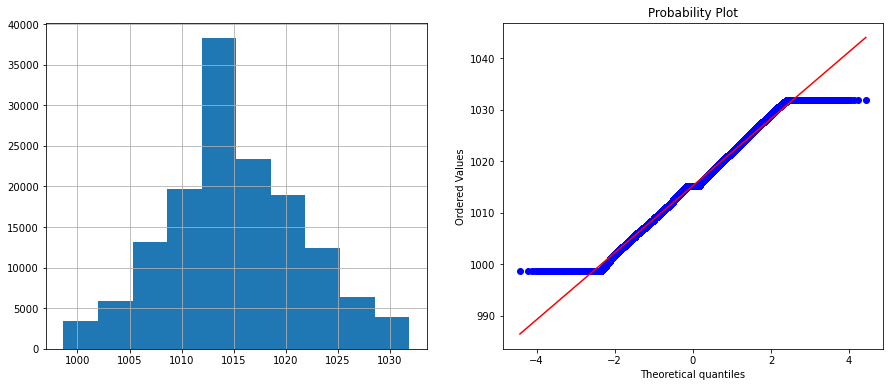

Temp9am


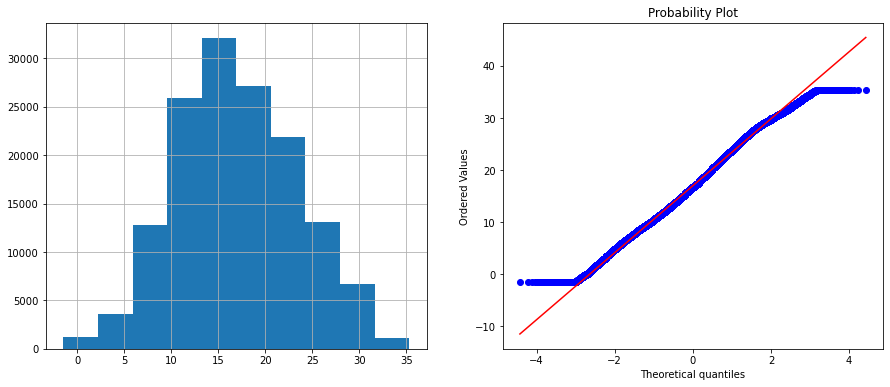

Temp3pm


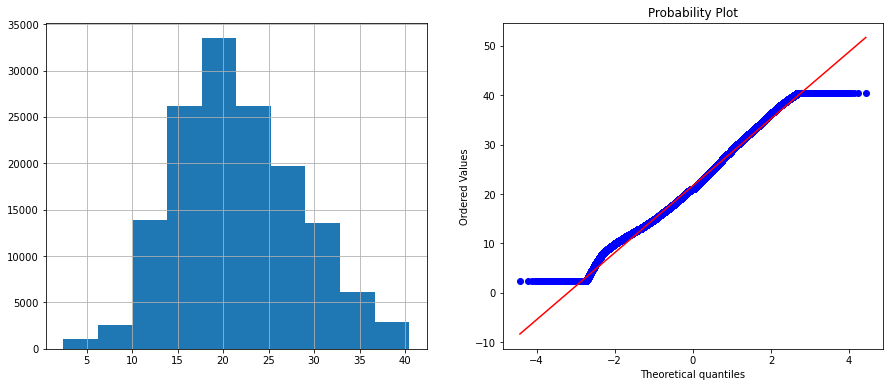

In [45]:
for feature in contineus_feature:
    print(feature)
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    dataset[feature].hist()
    plt.subplot(1, 2, 2)
    stats.probplot(dataset[feature], dist="norm", plot=plt)
    plt.show()

In [46]:
dataset.to_csv('preproce1.csv', index=False)

In [47]:
X=dataset.drop(['RainTomorrow', 'Date'], axis=1)
Y=dataset['RainTomorrow']

In [48]:
X_train, X_test, Y_train, Y_test=train_test_split(X,Y, test_size=0.2, stratify=Y, random_state=0)

In [49]:
smote=SMOTE(random_state=0)
Xtrain, Ytrain=smote.fit_resample(X_train, Y_train)
print('total number of classes before fit {}'.format(Counter(Y_train)))
print('total number of classes after fit {}'.format(Counter(Ytrain)))

total number of classes before fit Counter({0: 90866, 1: 25502})
total number of classes after fit Counter({0: 90866, 1: 90866})


In [50]:
cat=CatBoostClassifier(iterations=2000, eval_metric="AUC")
cat.fit(Xtrain, Ytrain)

Learning rate set to 0.050311
0:	total: 286ms	remaining: 9m 32s
1:	total: 373ms	remaining: 6m 12s
2:	total: 456ms	remaining: 5m 3s
3:	total: 554ms	remaining: 4m 36s
4:	total: 660ms	remaining: 4m 23s
5:	total: 769ms	remaining: 4m 15s
6:	total: 884ms	remaining: 4m 11s
7:	total: 982ms	remaining: 4m 4s
8:	total: 1.11s	remaining: 4m 4s
9:	total: 1.21s	remaining: 4m 1s
10:	total: 1.33s	remaining: 4m
11:	total: 1.45s	remaining: 3m 59s
12:	total: 1.55s	remaining: 3m 57s
13:	total: 1.66s	remaining: 3m 56s
14:	total: 1.77s	remaining: 3m 54s
15:	total: 1.89s	remaining: 3m 53s
16:	total: 1.99s	remaining: 3m 52s
17:	total: 2.1s	remaining: 3m 51s
18:	total: 2.21s	remaining: 3m 50s
19:	total: 2.32s	remaining: 3m 49s
20:	total: 2.43s	remaining: 3m 49s
21:	total: 2.55s	remaining: 3m 49s
22:	total: 2.65s	remaining: 3m 48s
23:	total: 2.76s	remaining: 3m 47s
24:	total: 2.87s	remaining: 3m 46s
25:	total: 2.97s	remaining: 3m 45s
26:	total: 3.08s	remaining: 3m 44s
27:	total: 3.18s	remaining: 3m 43s
28:	total

233:	total: 22.8s	remaining: 2m 52s
234:	total: 22.9s	remaining: 2m 52s
235:	total: 23s	remaining: 2m 52s
236:	total: 23.1s	remaining: 2m 51s
237:	total: 23.2s	remaining: 2m 51s
238:	total: 23.3s	remaining: 2m 51s
239:	total: 23.4s	remaining: 2m 51s
240:	total: 23.5s	remaining: 2m 51s
241:	total: 23.6s	remaining: 2m 51s
242:	total: 23.6s	remaining: 2m 50s
243:	total: 23.7s	remaining: 2m 50s
244:	total: 23.8s	remaining: 2m 50s
245:	total: 23.9s	remaining: 2m 50s
246:	total: 24s	remaining: 2m 50s
247:	total: 24.1s	remaining: 2m 49s
248:	total: 24.1s	remaining: 2m 49s
249:	total: 24.2s	remaining: 2m 49s
250:	total: 24.3s	remaining: 2m 49s
251:	total: 24.4s	remaining: 2m 49s
252:	total: 24.5s	remaining: 2m 49s
253:	total: 24.6s	remaining: 2m 49s
254:	total: 24.7s	remaining: 2m 49s
255:	total: 24.8s	remaining: 2m 48s
256:	total: 24.9s	remaining: 2m 48s
257:	total: 25s	remaining: 2m 48s
258:	total: 25.1s	remaining: 2m 48s
259:	total: 25.2s	remaining: 2m 48s
260:	total: 25.3s	remaining: 2m 48

463:	total: 43.9s	remaining: 2m 25s
464:	total: 44s	remaining: 2m 25s
465:	total: 44s	remaining: 2m 24s
466:	total: 44.1s	remaining: 2m 24s
467:	total: 44.2s	remaining: 2m 24s
468:	total: 44.3s	remaining: 2m 24s
469:	total: 44.4s	remaining: 2m 24s
470:	total: 44.5s	remaining: 2m 24s
471:	total: 44.6s	remaining: 2m 24s
472:	total: 44.6s	remaining: 2m 24s
473:	total: 44.7s	remaining: 2m 23s
474:	total: 44.8s	remaining: 2m 23s
475:	total: 44.9s	remaining: 2m 23s
476:	total: 45s	remaining: 2m 23s
477:	total: 45s	remaining: 2m 23s
478:	total: 45.1s	remaining: 2m 23s
479:	total: 45.2s	remaining: 2m 23s
480:	total: 45.3s	remaining: 2m 23s
481:	total: 45.4s	remaining: 2m 22s
482:	total: 45.5s	remaining: 2m 22s
483:	total: 45.6s	remaining: 2m 22s
484:	total: 45.7s	remaining: 2m 22s
485:	total: 45.8s	remaining: 2m 22s
486:	total: 45.8s	remaining: 2m 22s
487:	total: 45.9s	remaining: 2m 22s
488:	total: 46s	remaining: 2m 22s
489:	total: 46.1s	remaining: 2m 22s
490:	total: 46.2s	remaining: 2m 21s
49

697:	total: 1m 4s	remaining: 1m 59s
698:	total: 1m 4s	remaining: 1m 59s
699:	total: 1m 4s	remaining: 1m 59s
700:	total: 1m 4s	remaining: 1m 59s
701:	total: 1m 4s	remaining: 1m 59s
702:	total: 1m 4s	remaining: 1m 59s
703:	total: 1m 4s	remaining: 1m 59s
704:	total: 1m 4s	remaining: 1m 59s
705:	total: 1m 4s	remaining: 1m 59s
706:	total: 1m 5s	remaining: 1m 58s
707:	total: 1m 5s	remaining: 1m 58s
708:	total: 1m 5s	remaining: 1m 58s
709:	total: 1m 5s	remaining: 1m 58s
710:	total: 1m 5s	remaining: 1m 58s
711:	total: 1m 5s	remaining: 1m 58s
712:	total: 1m 5s	remaining: 1m 58s
713:	total: 1m 5s	remaining: 1m 58s
714:	total: 1m 5s	remaining: 1m 58s
715:	total: 1m 5s	remaining: 1m 58s
716:	total: 1m 5s	remaining: 1m 57s
717:	total: 1m 5s	remaining: 1m 57s
718:	total: 1m 6s	remaining: 1m 57s
719:	total: 1m 6s	remaining: 1m 57s
720:	total: 1m 6s	remaining: 1m 57s
721:	total: 1m 6s	remaining: 1m 57s
722:	total: 1m 6s	remaining: 1m 57s
723:	total: 1m 6s	remaining: 1m 57s
724:	total: 1m 6s	remaining:

922:	total: 1m 24s	remaining: 1m 38s
923:	total: 1m 24s	remaining: 1m 38s
924:	total: 1m 24s	remaining: 1m 38s
925:	total: 1m 24s	remaining: 1m 38s
926:	total: 1m 24s	remaining: 1m 38s
927:	total: 1m 24s	remaining: 1m 38s
928:	total: 1m 25s	remaining: 1m 38s
929:	total: 1m 25s	remaining: 1m 37s
930:	total: 1m 25s	remaining: 1m 37s
931:	total: 1m 25s	remaining: 1m 37s
932:	total: 1m 25s	remaining: 1m 37s
933:	total: 1m 25s	remaining: 1m 37s
934:	total: 1m 25s	remaining: 1m 37s
935:	total: 1m 25s	remaining: 1m 37s
936:	total: 1m 25s	remaining: 1m 37s
937:	total: 1m 25s	remaining: 1m 37s
938:	total: 1m 26s	remaining: 1m 37s
939:	total: 1m 26s	remaining: 1m 37s
940:	total: 1m 26s	remaining: 1m 37s
941:	total: 1m 26s	remaining: 1m 36s
942:	total: 1m 26s	remaining: 1m 36s
943:	total: 1m 26s	remaining: 1m 36s
944:	total: 1m 26s	remaining: 1m 36s
945:	total: 1m 26s	remaining: 1m 36s
946:	total: 1m 26s	remaining: 1m 36s
947:	total: 1m 26s	remaining: 1m 36s
948:	total: 1m 26s	remaining: 1m 36s
9

1140:	total: 1m 43s	remaining: 1m 18s
1141:	total: 1m 44s	remaining: 1m 18s
1142:	total: 1m 44s	remaining: 1m 18s
1143:	total: 1m 44s	remaining: 1m 17s
1144:	total: 1m 44s	remaining: 1m 17s
1145:	total: 1m 44s	remaining: 1m 17s
1146:	total: 1m 44s	remaining: 1m 17s
1147:	total: 1m 44s	remaining: 1m 17s
1148:	total: 1m 44s	remaining: 1m 17s
1149:	total: 1m 44s	remaining: 1m 17s
1150:	total: 1m 44s	remaining: 1m 17s
1151:	total: 1m 44s	remaining: 1m 17s
1152:	total: 1m 45s	remaining: 1m 17s
1153:	total: 1m 45s	remaining: 1m 17s
1154:	total: 1m 45s	remaining: 1m 16s
1155:	total: 1m 45s	remaining: 1m 16s
1156:	total: 1m 45s	remaining: 1m 16s
1157:	total: 1m 45s	remaining: 1m 16s
1158:	total: 1m 45s	remaining: 1m 16s
1159:	total: 1m 45s	remaining: 1m 16s
1160:	total: 1m 45s	remaining: 1m 16s
1161:	total: 1m 45s	remaining: 1m 16s
1162:	total: 1m 45s	remaining: 1m 16s
1163:	total: 1m 45s	remaining: 1m 16s
1164:	total: 1m 46s	remaining: 1m 16s
1165:	total: 1m 46s	remaining: 1m 15s
1166:	total:

1363:	total: 2m 3s	remaining: 57.8s
1364:	total: 2m 3s	remaining: 57.7s
1365:	total: 2m 4s	remaining: 57.6s
1366:	total: 2m 4s	remaining: 57.5s
1367:	total: 2m 4s	remaining: 57.4s
1368:	total: 2m 4s	remaining: 57.3s
1369:	total: 2m 4s	remaining: 57.2s
1370:	total: 2m 4s	remaining: 57.1s
1371:	total: 2m 4s	remaining: 57s
1372:	total: 2m 4s	remaining: 56.9s
1373:	total: 2m 4s	remaining: 56.8s
1374:	total: 2m 4s	remaining: 56.7s
1375:	total: 2m 4s	remaining: 56.6s
1376:	total: 2m 4s	remaining: 56.5s
1377:	total: 2m 5s	remaining: 56.5s
1378:	total: 2m 5s	remaining: 56.4s
1379:	total: 2m 5s	remaining: 56.3s
1380:	total: 2m 5s	remaining: 56.2s
1381:	total: 2m 5s	remaining: 56.1s
1382:	total: 2m 5s	remaining: 56s
1383:	total: 2m 5s	remaining: 55.9s
1384:	total: 2m 5s	remaining: 55.8s
1385:	total: 2m 5s	remaining: 55.7s
1386:	total: 2m 5s	remaining: 55.6s
1387:	total: 2m 5s	remaining: 55.5s
1388:	total: 2m 5s	remaining: 55.4s
1389:	total: 2m 6s	remaining: 55.3s
1390:	total: 2m 6s	remaining: 55

1589:	total: 2m 23s	remaining: 37s
1590:	total: 2m 23s	remaining: 36.9s
1591:	total: 2m 23s	remaining: 36.8s
1592:	total: 2m 23s	remaining: 36.7s
1593:	total: 2m 23s	remaining: 36.6s
1594:	total: 2m 23s	remaining: 36.5s
1595:	total: 2m 23s	remaining: 36.4s
1596:	total: 2m 23s	remaining: 36.3s
1597:	total: 2m 24s	remaining: 36.2s
1598:	total: 2m 24s	remaining: 36.1s
1599:	total: 2m 24s	remaining: 36.1s
1600:	total: 2m 24s	remaining: 36s
1601:	total: 2m 24s	remaining: 35.9s
1602:	total: 2m 24s	remaining: 35.8s
1603:	total: 2m 24s	remaining: 35.7s
1604:	total: 2m 24s	remaining: 35.6s
1605:	total: 2m 24s	remaining: 35.5s
1606:	total: 2m 24s	remaining: 35.4s
1607:	total: 2m 24s	remaining: 35.3s
1608:	total: 2m 24s	remaining: 35.2s
1609:	total: 2m 25s	remaining: 35.1s
1610:	total: 2m 25s	remaining: 35.1s
1611:	total: 2m 25s	remaining: 35s
1612:	total: 2m 25s	remaining: 34.9s
1613:	total: 2m 25s	remaining: 34.8s
1614:	total: 2m 25s	remaining: 34.7s
1615:	total: 2m 25s	remaining: 34.6s
1616:	t

1814:	total: 2m 42s	remaining: 16.6s
1815:	total: 2m 42s	remaining: 16.5s
1816:	total: 2m 42s	remaining: 16.4s
1817:	total: 2m 42s	remaining: 16.3s
1818:	total: 2m 43s	remaining: 16.2s
1819:	total: 2m 43s	remaining: 16.1s
1820:	total: 2m 43s	remaining: 16s
1821:	total: 2m 43s	remaining: 16s
1822:	total: 2m 43s	remaining: 15.9s
1823:	total: 2m 43s	remaining: 15.8s
1824:	total: 2m 43s	remaining: 15.7s
1825:	total: 2m 43s	remaining: 15.6s
1826:	total: 2m 43s	remaining: 15.5s
1827:	total: 2m 43s	remaining: 15.4s
1828:	total: 2m 43s	remaining: 15.3s
1829:	total: 2m 44s	remaining: 15.2s
1830:	total: 2m 44s	remaining: 15.1s
1831:	total: 2m 44s	remaining: 15.1s
1832:	total: 2m 44s	remaining: 15s
1833:	total: 2m 44s	remaining: 14.9s
1834:	total: 2m 44s	remaining: 14.8s
1835:	total: 2m 44s	remaining: 14.7s
1836:	total: 2m 44s	remaining: 14.6s
1837:	total: 2m 44s	remaining: 14.5s
1838:	total: 2m 44s	remaining: 14.4s
1839:	total: 2m 44s	remaining: 14.3s
1840:	total: 2m 44s	remaining: 14.2s
1841:	t

In [51]:
Y_predic=cat.predict(X_test)
print(confusion_matrix(Y_test, Y_predic))
print(accuracy_score(Y_test, Y_predic))
print(classification_report(Y_test, Y_predic))

[[21521  1196]
 [ 2799  3576]]
0.862677024611577
              precision    recall  f1-score   support

           0       0.88      0.95      0.92     22717
           1       0.75      0.56      0.64      6375

    accuracy                           0.86     29092
   macro avg       0.82      0.75      0.78     29092
weighted avg       0.86      0.86      0.86     29092



0.7541466898332164

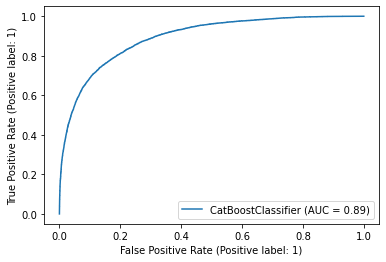

In [52]:
metrics.plot_roc_curve(cat, X_test, Y_test)
metrics.roc_auc_score(Y_test, Y_predic, average=None) 

In [53]:
randomforest=RandomForestClassifier()
randomforest.fit(Xtrain, Ytrain)

RandomForestClassifier()

In [54]:
rf_y_predic=randomforest.predict(X_test)
print(confusion_matrix(Y_test, rf_y_predic))
print(accuracy_score(Y_test, rf_y_predic))
print(classification_report(Y_test, rf_y_predic))

[[20625  2092]
 [ 2446  3929]]
0.844012099546267
              precision    recall  f1-score   support

           0       0.89      0.91      0.90     22717
           1       0.65      0.62      0.63      6375

    accuracy                           0.84     29092
   macro avg       0.77      0.76      0.77     29092
weighted avg       0.84      0.84      0.84     29092



0.7621120504899587

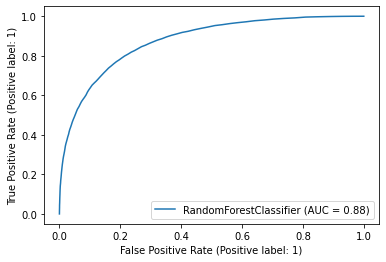

In [55]:
metrics.plot_roc_curve(randomforest, X_test, Y_test)
metrics.roc_auc_score(Y_test, rf_y_predic, average=None) 

In [56]:
logest=LogisticRegression()
logest.fit(Xtrain, Ytrain)

C:\Users\swapn\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [57]:
log_y_predic=logest.predict(X_test)
print(confusion_matrix(Y_test, log_y_predic))
print(accuracy_score(Y_test, log_y_predic))
print(classification_report(Y_test, log_y_predic))




[[17731  4986]
 [ 1557  4818]]
0.7750928090196617
              precision    recall  f1-score   support

           0       0.92      0.78      0.84     22717
           1       0.49      0.76      0.60      6375

    accuracy                           0.78     29092
   macro avg       0.71      0.77      0.72     29092
weighted avg       0.83      0.78      0.79     29092



0.768140749736528

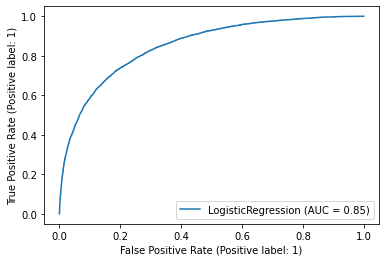

In [58]:
metrics.plot_roc_curve(logest, X_test, Y_test)
metrics.roc_auc_score(Y_test, log_y_predic, average=None)

In [59]:
GNB = GaussianNB()
GNB.fit(Xtrain, Ytrain)

GaussianNB()

In [60]:
gnb_y_predic=GNB.predict(X_test)
print(confusion_matrix(Y_test, gnb_y_predic))
print(accuracy_score(Y_test, gnb_y_predic))
print(classification_report(Y_test, gnb_y_predic))

[[17068  5649]
 [ 1659  4716]]
0.7487969201154957
              precision    recall  f1-score   support

           0       0.91      0.75      0.82     22717
           1       0.45      0.74      0.56      6375

    accuracy                           0.75     29092
   macro avg       0.68      0.75      0.69     29092
weighted avg       0.81      0.75      0.77     29092



0.7455481538832023

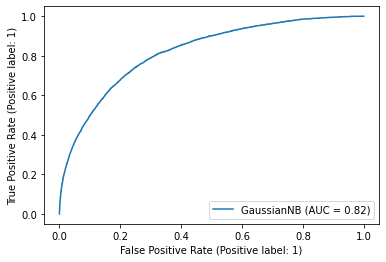

In [61]:
metrics.plot_roc_curve(GNB, X_test, Y_test)
metrics.roc_auc_score(Y_test, gnb_y_predic, average=None)

In [62]:
knn=KNeighborsClassifier()
knn.fit(Xtrain, Ytrain)

KNeighborsClassifier()

In [63]:
knn_Y_predic=knn.predict(X_test)
print(confusion_matrix(Y_test, knn_Y_predic))
print(accuracy_score(Y_test, knn_Y_predic))
print(classification_report(Y_test, knn_Y_predic))

[[16819  5898]
 [ 1569  4806]]
0.7433315000687474
              precision    recall  f1-score   support

           0       0.91      0.74      0.82     22717
           1       0.45      0.75      0.56      6375

    accuracy                           0.74     29092
   macro avg       0.68      0.75      0.69     29092
weighted avg       0.81      0.74      0.76     29092



0.7471265002369306

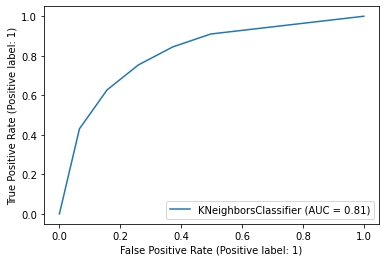

In [64]:
metrics.plot_roc_curve(knn, X_test, Y_test)
metrics.roc_auc_score(Y_test, knn_Y_predic, average=None)

In [65]:
xgb=XGBClassifier()
xgb.fit(Xtrain, Ytrain)

C:\Users\swapn\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:31:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [66]:
xgb_y_predic=xgb.predict(X_test)
print(classification_report(Y_test, xgb_y_predic))
print(accuracy_score(Y_test, xgb_y_predic))
print(classification_report(Y_test, xgb_y_predic))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91     22717
           1       0.72      0.56      0.63      6375

    accuracy                           0.86     29092
   macro avg       0.80      0.75      0.77     29092
weighted avg       0.85      0.86      0.85     29092

0.8563866355011687
              precision    recall  f1-score   support

           0       0.88      0.94      0.91     22717
           1       0.72      0.56      0.63      6375

    accuracy                           0.86     29092
   macro avg       0.80      0.75      0.77     29092
weighted avg       0.85      0.86      0.85     29092



0.7483698051126952

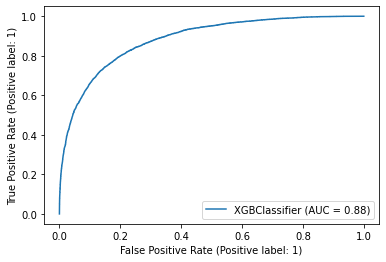

In [67]:
metrics.plot_roc_curve(xgb, X_test, Y_test)
metrics.roc_auc_score(Y_test, xgb_y_predic, average=None)


In [70]:
joblib.dump(cat, 'cat.pkl')
joblib.dump(knn, 'knn.pkl')
joblib.dump(logest, 'logest.pkl')
joblib.dump(xgb, "xgb.pkl")

['xgb.pkl']